# 2 - Show summary glacier evolution time series and steady-state mass estimates dependent on the applied climate experiment

- creates **Figure 1, 2 and several supplementary figures (variants of Fig. 2)**
    - global plot, and for every RGI region, showing results by always using median (and quantiles) of glacier models 
    - creates figures of global vs regional warming (for supplements)

--- 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
import matplotlib.colors
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous, compute_steady_state_yr, cmap, scaler, get_glob_temp_exp
from scipy.optimize import curve_fit

fit_to_median = False

######## this should be the same everywhere... 
DATE = 'Feb12_2024' 
fill_option = 'repeat_last_101yrs' 
path_merged_runs_scaled_extend = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)
pd_rgi_stats_w_hugonnet = pd.read_csv(f'../data/3_shift_summary_region_characteristics{DATE}.csv', index_col=[0])

approach = '_via_5yravg'
ds_reg_yr_shift= xr.open_dataset(f'../data/GMIP3_reg_glacier_model_data/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')
pd_lowess_fit = pd.read_csv(f'../data/lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}.csv', index_col=[0])
pd_lowess_fit.index = pd_lowess_fit.temp_ch
pd_lowess_fit.index = pd_lowess_fit.index.values.round(2)

pd_global_temp_exp = pd.read_csv('../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b.csv', index_col = 0)
pd_global_temp_exp_glac = pd.read_csv(f'../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv', index_col = 0)


In [2]:
hue_order_anonymous = []

pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
ds_reg_models = ds_reg_models.sel(model_author = hue_order)
pal_models = sns.color_palette(pal_models)

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
    
# select the right models
ds_reg_models = ds_reg_models.sel(model_author=hue_order)
ds_reg_models_vol = ds_reg_models.volume_m3

glac_models = hue_order

['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


In [3]:
# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 

ds_reg_yr_shift = ds_reg_yr_shift.sel(model_author=glac_models)
ds_reg_yr_shift_vol = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950)).volume_m3
ds_reg_yr_shift_vol = ds_reg_yr_shift_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_yr_shift_vol_med = ds_reg_yr_shift_vol.median(dim='model_author')

In [4]:
# values not shown in the text 
temp = 1.2
pd_lowess_fit.loc[pd_lowess_fit.index.values.round(2) ==temp].sort_values(by='0.5')

temp_ch       0.05       0.17       0.25        0.5       0.75  \
1.2      1.2   4.558348   5.913058   6.874178  14.814271  16.839394   
1.2      1.2   4.211776   6.943953   7.405570  25.869422  52.695622   
1.2      1.2   7.323212  14.778353  17.231018  34.479821  58.934096   
1.2      1.2  13.115153  20.276083  23.067428  35.366239  49.265995   
1.2      1.2  19.172725  26.753756  27.404976  39.350361  56.556418   
1.2      1.2  24.709283  28.106427  31.285039  41.796096  51.075064   
1.2      1.2  34.326100  38.757701  39.744708  43.846156  45.549272   
1.2      1.2  23.844841  27.569566  29.614433  44.179935  49.964611   
1.2      1.2  34.225079  36.632240  37.296688  51.404270  74.388022   
1.2      1.2  32.709514  38.630235  44.361358  53.750907  69.074403   
1.2      1.2  37.989790  44.739666  48.120426  60.852809  68.394504   
1.2      1.2  36.609403  43.242014  53.783937  61.174456  73.972874   
1.2      1.2  39.000518  49.056981  52.875903  62.601846  68.155237   
1.2      1.2  39.894077  48.115630  52.810193  64.306192  93.852246   
1.2      1.2  28.681539  32.983408  47.887415  67.455467  90.769405   
1.2      1.2  52.627506  63.381706  68.250120  76.666787  95.429730   
1.2      1.2  59.401208  65.405636  70.581019  77.274084  84.413052   
1.2      1.2  36.631899  61.018363  67.522757  84.547966  91.238788   
1.2      1.2  62.749219  68.319281  74.942270  87.749007  95.003851   
1.2      1.2  63.966654  70.421442  76.643842  94.543225  97.620429   

           0.83        0.95  frac region  year  it    N  
1.2   17.082638   24.004891  0.27     04  5000   2  500  
1.2   56.519919   78.463243  0.26     02  5000   2  500  
1.2   76.380145  138.199629  0.79     08  5000   2  500  
1.2   54.332618   69.742440  0.87     09  5000   2  500  
1.2   61.197645   78.556269  0.24     06  5000   2  500  
1.2   58.206160   72.456784  0.34     05  5000   2  500  
1.2   47.640585   56.323977  0.25     11  5000   2  500  
1.2   54.379472   59.207822  0.17     10  5000   2  500  
1.2   81.877525   94.456554  0.18     15  5000   2  500  
1.2   74.944405   79.161388  0.43     07  5000   2  500  
1.2   85.386515   93.965311  0.23    All  5000   2  500  
1.2   78.933050   86.415670  0.24     17  5000   2  500  
1.2   69.747471   78.225066  0.29     01  5000   2  500  
1.2  120.761026  144.121755  0.57     19  5000   2  500  
1.2  100.584076  111.047925  0.28     03  5000   2  500  
1.2  107.689486  137.349989  0.24     16  5000   2  500  
1.2   84.998114  104.793025  0.18     12  5000   2  500  
1.2   97.682862  151.997674  0.29     18  5000   2  500  
1.2   97.368143  110.388294  0.21     13  5000   2  500  
1.2  100.182382  112.763029  0.23     14  5000   2  500

In [5]:
# values not shown in the text 
temp = 3
pd_lowess_fit.loc[pd_lowess_fit.index.values.round(2) ==temp]#['0.5']

temp_ch       0.05       0.17       0.25        0.5       0.75  \
3.0      3.0  11.851006  17.928928  20.668470  29.326077  47.957396   
3.0      3.0   0.241325   0.390108   0.478400   1.157221   3.501440   
3.0      3.0   8.382726  16.504302  20.715270  28.890645  50.897228   
3.0      3.0   0.048285   0.090637   0.187269   0.599517   2.764249   
3.0      3.0   0.605179   3.898187   5.414409  10.812421  18.086451   
3.0      3.0   0.232298   0.426069   0.621985   2.871898  12.382086   
3.0      3.0   0.006486   0.077309   0.255289   4.729440  20.670151   
3.0      3.0   0.000000   0.000000   0.000000   0.000000   0.000000   
3.0      3.0   0.000000   0.000000   0.000000   0.000000   6.399217   
3.0      3.0   2.571673   3.887010   4.298909   5.843914   8.117982   
3.0      3.0   2.247613   3.241588   3.444621   4.914818   6.340647   
3.0      3.0   6.919606  10.071957  10.258796  13.481102  20.283572   
3.0      3.0   8.626275  10.779959  12.815143  20.121870  42.192120   
3.0      3.0  13.522616  16.426668  17.662934  32.221843  54.760110   
3.0      3.0   5.863081   7.309654   7.875152  11.828937  23.499255   
3.0      3.0   5.000274   6.674787   7.540356   9.258803  12.875631   
3.0      3.0  12.804175  16.447341  19.357758  32.157156  45.397125   
3.0      3.0  10.280786  19.513911  22.423071  32.802620  42.528165   
3.0      3.0  10.945185  15.348880  18.394341  30.486494  53.208079   
3.0      3.0  10.418115  15.064328  16.595811  22.587879  35.320086   

          0.83       0.95  frac region  year  it    N  
3.0  52.863254  59.826794  0.29     01  5000   2  500  
3.0   5.761473  10.821487  0.26     02  5000   2  500  
3.0  65.442135  80.884490  0.28     03  5000   2  500  
3.0   3.984534  11.157221  0.27     04  5000   2  500  
3.0  27.030169  34.302674  0.34     05  5000   2  500  
3.0  17.346728  35.091260  0.24     06  5000   2  500  
3.0  29.963996  41.568087  0.43     07  5000   2  500  
3.0   0.000000   5.630182  0.79     08  5000   2  500  
3.0   9.998468  20.305062  0.87     09  5000   2  500  
3.0   9.329416  13.062962  0.17     10  5000   2  500  
3.0   6.776466   7.861010  0.25     11  5000   2  500  
3.0  24.174126  36.516138  0.18     12  5000   2  500  
3.0  47.551515  58.032398  0.21     13  5000   2  500  
3.0  59.601338  66.933323  0.23     14  5000   2  500  
3.0  31.601633  49.645248  0.18     15  5000   2  500  
3.0  18.623874  33.143020  0.24     16  5000   2  500  
3.0  55.191531  62.525868  0.24     17  5000   2  500  
3.0  47.720236  58.869233  0.29     18  5000   2  500  
3.0  68.602281  86.574196  0.57     19  5000   2  500  
3.0  39.623534  52.298056  0.23    All  5000   2  500

In [6]:
# values not shown in the text 
temp = 5
pd_lowess_fit.loc[pd_lowess_fit.index.values.round(2) ==temp]#['0.5']

temp_ch      0.05      0.17      0.25        0.5       0.75       0.83  \
5.0      5.0  3.114777  5.212568  6.161626  12.700423  31.828242  34.667839   
5.0      5.0  0.006573  0.041851  0.061500   0.167772   0.376585   0.582058   
5.0      5.0  0.565129  1.136272  1.561223   7.166822  14.800441  25.966074   
5.0      5.0  0.000000  0.007242  0.016472   0.033528   0.178803   0.528919   
5.0      5.0  0.144975  0.549382  0.982500   2.326048   5.020061   6.607213   
5.0      5.0  0.019382  0.086651  0.117074   0.347226   1.391612   2.554725   
5.0      5.0  0.001598  0.009871  0.065706   1.340987   9.334666  16.774226   
5.0      5.0  0.000000  0.000000  0.000000   0.000000   0.000000   0.346922   
5.0      5.0  0.000000  0.000000  0.000000   0.000000   2.541183   4.720211   
5.0      5.0  0.257649  0.433322  0.517470   0.828523   1.307347   1.559557   
5.0      5.0  0.125846  0.184000  0.244013   0.465358   0.791950   1.020083   
5.0      5.0  0.819782  1.438541  1.856325   2.458124   3.621424   8.529584   
5.0      5.0  1.549050  2.100975  3.219714   4.376105  15.857432  20.548329   
5.0      5.0  4.272623  5.694815  7.004286  13.141139  32.499003  37.550496   
5.0      5.0  1.074356  1.971921  2.439158   4.493955  11.296284  14.718076   
5.0      5.0  0.892141  1.100417  1.309816   1.890064   2.958548   4.012197   
5.0      5.0  3.755600  5.818520  7.270227  14.487998  27.194660  32.423044   
5.0      5.0  2.107125  4.182724  9.030854  11.846574  14.639886  15.673185   
5.0      5.0  3.950684  5.721312  7.554359  17.270706  27.566557  32.377240   
5.0      5.0  3.202345  4.473935  5.307401   9.076928  16.451543  18.075130   

          0.95  frac region  year  it    N  
5.0  44.678119  0.29     01  5000   2  500  
5.0   2.390427  0.26     02  5000   2  500  
5.0  53.284495  0.28     03  5000   2  500  
5.0   4.070194  0.27     04  5000   2  500  
5.0  17.713415  0.34     05  5000   2  500  
5.0   7.546173  0.24     06  5000   2  500  
5.0  23.946236  0.43     07  5000   2  500  
5.0   3.623991  0.79     08  5000   2  500  
5.0  10.891950  0.87     09  5000   2  500  
5.0   2.246216  0.17     10  5000   2  500  
5.0   1.658151  0.25     11  5000   2  500  
5.0  10.836430  0.18     12  5000   2  500  
5.0  26.819565  0.21     13  5000   2  500  
5.0  45.408541  0.23     14  5000   2  500  
5.0  24.005063  0.18     15  5000   2  500  
5.0   8.140034  0.24     16  5000   2  500  
5.0  39.663722  0.24     17  5000   2  500  
5.0  19.551950  0.29     18  5000   2  500  
5.0  47.410320  0.57     19  5000   2  500  
5.0  24.433222  0.23    All  5000   2  500

In [7]:
pd_global_temp_exp['temp_ch_ipcc'].min(), pd_global_temp_exp['temp_ch_ipcc'].max()

(-0.1435287751312741, 6.884361023524889)

## Estimate equilibrium glacier volume for any temperature level -> exponential decaying fit:

**Now create Fig. 2 with lowess fits**

In [23]:
qs = [0.05, 0.25, 0.5, 0.75, 0.95]
def func_subplot_warming_scatter(ax, rgi_reg='All', fig_1b=False,
                                show_leg2_in_subplot= True, path_only_glob='',
                                pd_sel='to_fill',
                                ): #pd_exp_decay_fits_simple='to_fill'): #, approach = approach, temp_ch

    ###########actually independent of rgi_reg
    pd_vol_2020 = pd_rgi_stats_w_hugonnet.copy()
    pd_sel['vol_2020_reg_m3'] = np.NaN
    for r in pd_sel.region.unique():
        vol_2020 = pd_vol_2020.loc[r, f'regional_volume_m3_2020{approach}']
        pd_sel.loc[pd_sel.region == r, 'vol_2020_reg_m3'] = vol_2020
    for q in qs:
        q = str(q)
        pd_sel[f'{q}_m3'] = pd_sel[f'{q}'] * pd_sel['vol_2020_reg_m3'] /100
    ###########actually independent of rgi_reg
    _rgi_reg = rgi_reg
    if temp_ch == 'regional_glacier':
        fs_label = 21
    else:
        fs_label = 23

    vol_2020_reg = pd_vol_2020.loc[_rgi_reg][f'regional_volume_m3_2020{approach}']

    region = f'RGI{rgi_reg}_glacier'
    
    #### first load the stuff as normally mostly needed for 'All'
    # (the ds_t2 are later overwritten, if a specific region is chosen)
    if path_only_glob != '_only_global_models':
        if shift_years:
            # we have done the dropping of everything after 4950, so the last year should be fine 
            ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.isel(year_after_2020=-1).sum(dim='rgi_reg')
            # make sure that we only take here global models ... 
            ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(year_after_2020=-1).dropna(dim='model_author')
            ds_t2 = 100*ds_t2/vol_2020_reg
            ds_t = 100*ds_reg_models_med_vol_sel/vol_2020_reg # TODO checkt that this is the sum ... 

        else:
            ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.isel(simulation_year=-1).sum(dim='rgi_reg')
            # make sure that we only take here global models ... 
            ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(simulation_year=-1).dropna(dim='model_author')
            ds_t2 = 100*ds_t2/ds_reg_models_vol.isel(simulation_year=0).sum(dim='rgi_reg', min_count=19)

            ds_t = 100*ds_reg_models_med_vol_sel/ds_reg_models_med_vol.isel(simulation_year=0).sum(dim='rgi_reg')
    else:
        # with global models -> first sum over the regions, and then do the 
        if shift_years:
            #  the median should here also be the median over the summed up values 
            ds_reg_models_med_vol_sel = ds_reg_models_vol_roll.isel(year_after_2020=-1).sum(dim='rgi_reg').median(dim='model_author')
            # make sure that we only take here global models ... 
            ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(year_after_2020=-1).dropna(dim='model_author')
            ds_t2 = 100*ds_t2/vol_2020_reg
            ds_t = 100*ds_reg_models_med_vol_sel/vol_2020_reg # TODO checkt that this is the sum ... 
        else:
            raise NotImplementedError()

    pd_tt2 = ds_t2.to_dataframe()
    try:
        pd_tt2 = pd_tt2.drop(columns=['gcm','period_scenario'])
    except:
        pass
    pd_tt2 = pd_tt2.reset_index()
    
    if rgi_reg == 'All':
        # get the temp.
        if temp_ch != 'regional_glacier':
            pd_global_temp_exp_m = get_glob_temp_exp(region='global')
        else:
            pd_global_temp_exp_m = get_glob_temp_exp(region='global_glacier')
    else:
        # get the temp. 
        if temp_ch != 'regional_glacier':
            pd_global_temp_exp_m = get_glob_temp_exp(region='global')
        else:
            pd_global_temp_exp_m = get_glob_temp_exp(region=region)

        if fit_to_median:
            if shift_years:
                # TODO
                ds_t2 = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(year_after_2020=-1).dropna(dim='model_author')
                ds_t2 = 100*ds_t2/vol_2020_reg
            else:
                ds_t2 = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(simulation_year=-1).dropna(dim='model_author')
                ds_t2 = 100*ds_t2/ds_reg_models_vol.isel(simulation_year=0).sel(rgi_reg=rgi_reg)
            ds_t = ds_t2.median(dim='model_author') 

            pd_tt2 = ds_t2.to_dataframe()
            try:
                pd_tt2 = pd_tt2.drop(columns=['gcm','period_scenario'])
            except:
                pass
            pd_tt2 = pd_tt2.reset_index()
        else:
            if shift_years:
                # TODO
                ds_t = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(year_after_2020=-1).dropna(dim='model_author')
                ds_t = 100*ds_t/vol_2020_reg
            else:
                ds_t = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(simulation_year=-1).dropna(dim='model_author')
                ds_t = 100*ds_t/ds_reg_models_vol.isel(simulation_year=0).sel(rgi_reg=rgi_reg)
    pd_tt = ds_t.to_dataframe()
    try:
        pd_tt = pd_tt.drop(columns=['gcm','period_scenario'])
    except:
        pass
    pd_tt = pd_tt.reset_index()
    print(pd_tt['volume_m3'].max())

    # much better if we create a gcm_period_scenario column to later assign the correct temp. series ... 
    pd_global_temp_exp_m_r = pd_global_temp_exp_m.reset_index()
    pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario'] = pd_global_temp_exp_m_r['gcm'] +'_'+pd_global_temp_exp_m_r['period_scenario']
    pd_global_temp_exp_m_r.index = pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario']
    pd_tt2['gcm'+'_'+'period_scenario'] = pd_tt2['gcm'] +'_'+pd_tt2['period_scenario']
    pd_tt2.index = pd_tt2['gcm'+'_'+'period_scenario']
    pd_tt2.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
    pd_tt2 = pd_tt2.reset_index(drop=True)

    pd_tt['gcm'+'_'+'period_scenario'] = pd_tt['gcm'] +'_'+pd_tt['period_scenario']
    pd_tt.index = pd_tt['gcm'+'_'+'period_scenario']
    pd_tt.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
    pd_tt = pd_tt.reset_index(drop=True)
    pd_tt_above0 = pd_tt #.loc[pd_tt.volume_m3>0]  ## probably it is ok to also fit the zero volume estimates 
    # if I want to remove the very uncertain experiments,
    # I still want to keep those that are near to 
    # 1.2°C. However, there are no experiments directly at 1.2°C
    # and only one at +1, so, we should rather do the fit with >= +0.8°C
    if temp_above_0_8:
        pd_tt_above0 = pd_tt_above0.loc[pd_tt_above0['temp_ch_ipcc']>=0.8]
    temp = pd_tt_above0['temp_ch_ipcc'].values

    q = 'volume_m3' # this is actually the 'relative volume change (in %)'
    rel_vol = pd_tt_above0[q].values
    
    if not fig_1b:
        if rgi_reg == 'All':
            ax.text(0.99, 0.99, 'Global', color='black',weight='bold',transform=ax.transAxes, fontsize=35, va='top', ha='right')
        else:
            nam = d_reg_num_name[rgi_reg]
            if rgi_reg == '19' and plot_fig2:
                fs_rgi = 23.5
            elif rgi_reg == '19' and not plot_fig2:
                fs_rgi = 26.5
            else:
                fs_rgi = 30
            if rgi_reg == '12' and plot_fig2:
                fs_rgi = 28
            if plot_fig2:
                fs_add = 3
                ax.text(0.988, 0.988, f'{nam}', color='black', weight='bold',transform=ax.transAxes, fontsize=fs_rgi+fs_add, va='top', ha='right')
            else:
                fs_add = 2
                ax.text(0.985, 0.985, f'{nam}', color='black', weight='bold',transform=ax.transAxes, fontsize=fs_rgi, va='top', ha='right') # {rgi_reg}-

    ax.set_ylabel(f'{state}\n(% rel. to 2020)', fontsize=32)
    if not fig_1b:
        if temp_ch == 'regional_glacier':
            leg2y =  0.53 # 0.59 #0.59
            delta_t = 0 #-0.05 #0 #-0.04
        else:
            leg2y = 0.59 #0.62
            delta_t = -0.01
    else:
        leg2y = 1
        delta_t = 0
    
    if show_color_models:                    
        if rgi_reg=='All':
            pd_ttx = pd_tt2
            pd_ttxx = pd_tt
            # add legend...
            n_models = len(pd_ttx.model_author.unique())
            if path_only_glob != '_only_global_models':
                label = 'sum of regional\n'+r'medians (n=80)' # global model median:\n'+r'$\sum_{rgi=1}^{19} V_{median,rgi}$'  ## at $\Delta$T'+'\n
                
            else:
                #label = 'median of global models:\n'+r'median ($\sum_{rgi=1}^{19} V_{rgi}$)'
                label = "global models'\n"+r'median (n=80)' #:\n'+r'median ($\sum_{rgi=1}^{19} V_{rgi}$)' # at $\Delta$T'+'\n

            line1 = Line2D([0], [0],
                           label=label,
                           color='black', ms=10, marker='o', lw=0,alpha = 0.8)
            if fig_1b:
                line2 = Line2D([0], [0], label='global glacier\n'+r'models', color='grey', ms=7, marker='s', lw=0,alpha = 0.6) #  at $\Delta$T
            else:
                line2 = Line2D([0], [0], label='glacier\n'+r'models', color='grey', ms=7, marker='s', lw=0,alpha = 0.6) #  at $\Delta$T
            #add handles
            handles_leg2= [line2, line1]
            labels_leg2 = [line2.get_label(),line1.get_label()]
            #add legend
            if show_leg2_in_subplot:
                if temp_ch == '':
                    loc_glob = 'lower left'
                else:
                    loc_glob = 'lower right'
                leg2=ax.legend(handles=[line1],labels=[line1.get_label()],
                               loc = loc_glob, fontsize=24,#20, #fs_label+3,
                               title_fontsize=20) #, bbox_to_anchor=(1,leg2y))
            
            if not fig_1b:
                if not show_text:
                    if plot_fig2:
                        leg2y = 0.7
                    else: 
                        leg2y = 0.91
                    ax.text(0.98,leg2y,f'{n_models} models', 
                             verticalalignment='top', horizontalalignment='right', fontsize=28,
                             transform=ax.transAxes)
                else:
                    #ax.text(0.98,0.55+delta_t,f'{n_models} global glacier models',transform=ax.transAxes, horizontalalignment = 'right',
                    #       fontsize=23.5)
                                        
                    if (temp_ch == ''and ylim1 ==150) or (rgi_reg != 'All'):
                        leg3 = ax.legend([line2], [f'{n_models} models'], loc = 'upper right', 
                                         bbox_to_anchor = (1, leg2y+0.01),framealpha=0.5, 
                                         # 0.98,0.54+delta_t,
                                         #horizontalalignment = 'right',transform=ax.transAxes,
                               fontsize=24)
                    else:
                        leg3 = ax.legend([line2, line1], [f'{n_models} models', line1.get_label()], loc = 'upper right', 
                                         bbox_to_anchor = (1, leg2y+0.01),framealpha=0.5, 
                                         # 0.98,0.54+delta_t,
                                         #horizontalalignment = 'right',transform=ax.transAxes,
                               fontsize=24)
                

        else:
            if fit_to_median:
                pd_ttx = pd_tt2
                pd_ttxx = pd_tt
            else:
                pd_ttx = pd_tt
                pd_ttxx = pd_tt[['temp_ch_ipcc', 'volume_m3']].groupby(['temp_ch_ipcc']).median().reset_index()
            n_models = len(pd_ttx.model_author.unique())
                        
            line1 = Line2D([0], [0], label = "glacier models'\n"+r"median (n=80)", color='black', ms=10, marker='o', lw=0,alpha = 0.8) #  at $\Delta$T
            line2 = Line2D([0], [0], label='glacier\n'+r'models', color='grey', ms=7, marker='s', lw=0,alpha = 0.6)  #  at $\Delta$T

            #add handles
            handles_leg2= [line2, line1]
            labels_leg2 = [line2.get_label(),line1.get_label()]
            #labels_1 = ['median',]
            #add legend
            if show_leg2_in_subplot:
                leg2=ax.legend(handles=[line1],labels=[line1.get_label()], #title='glacier models',
                                  loc = 'lower left', fontsize=24, title_fontsize=20, bbox_to_anchor=(0,0)) #1,leg2y))
            if not fig_1b:
                if not show_text:
                    if plot_fig2:
                        leg2y = 0.76 #0.7
                        _fs = 28
                    else: 
                        leg2y = 0.91
                        _fs = 24
                    ax.text(0.98,leg2y,f'{n_models} models', 
                             verticalalignment='top', horizontalalignment='right', fontsize=_fs,
                            transform=ax.transAxes)
                else:
                    framealpha = 0.5
                    if (temp_ch == ''and ylim1 ==150) or (rgi_reg != 'All'):
                        leg3 = ax.legend([line2], [f'{n_models} models'], loc = 'upper right', 
                                         bbox_to_anchor = (1, leg2y),framealpha=0.5, 
                                         # 0.98,0.54+delta_t,
                                         #horizontalalignment = 'right',transform=ax.transAxes,
                               fontsize=24) #4)
                    else:
                        leg3 = ax.legend([line2, line1], [f'{n_models} models', line1.get_label()], loc = 'upper right', 
                                         bbox_to_anchor = (1, leg2y),framealpha=0.5, 
                                         # 0.98,0.54+delta_t,
                                         #horizontalalignment = 'right',transform=ax.transAxes,
                               fontsize=24)
        if show_models_in_grey:
            sns.scatterplot(ax=ax,x='temp_ch_ipcc',
                y='volume_m3', #'volume (km3)',
                data = pd_ttx,
                            color='darkgrey',
                legend=False, s=40, alpha = 1, marker='s')
        else:
            sns.scatterplot(ax=ax,x='temp_ch_ipcc',
                            y='volume_m3', #'volume (km3)',
                            data = pd_ttx,
                            hue_order=hue_order,
                            hue='model_author',
                            palette=pal_models,
                            legend=False, s=40, alpha = 1, marker='s')
        # if globally, the median comes from all estimates (also from those models that are only available for some RGI regions ...)
        # but it is the median over the experiments, so it should be ok, to do that, 
        # the lowess fit for the median is also done over these medians (80 exps.) separately (rel. to global glacier-area temp., so 
        # there the fit is ok to have (but not the uncertainties, as those are, at the moment coming directly from the sum of the exps)
        sns.scatterplot(ax=ax,
                    x='temp_ch_ipcc',
                    y='volume_m3', #'volume (km3)',
                    data = pd_ttxx,
                    color='black',
                    #hue='temp_ch_ipcc',
                    #palette='flare',
                    legend=False, s=80, alpha = 1)

    else:
        sns.scatterplot(ax=ax,
                    x='temp_ch_ipcc',
                    y='volume_m3', #'volume (km3)',
                    data = pd_tt,
                    color='black',
                    #hue='temp_ch_ipcc',
                    #palette='flare',
                    legend=False, s=80, alpha = 0.3)
    if temp_ch == 'regional_glacier':
        ax.set_xlabel(r'$\Delta$T$_{g}$ (°C)', fontsize=30) #_{reg,glacier-area}$ (°C)') #, compared to pre-industrial
    else:
        #ax.set_xlabel(r'$\Delta$T$_{global}$ (°C, compared to pre-industrial)')
        ax.set_xlabel(r'$\Delta$T (°C)', fontsize=30)

    #plt.plot(temp, rel_vol, 'o', alpha =0.2)
    x,y = temp, rel_vol
    popt, pcov = curve_fit(exponential_decay, x-current_deltaT, y,loss='soft_l1', f_scale=0.1, bounds = param_bounds)  # Lower and upper bounds for a and b)
    a_opt, b_opt = popt
    x_dense = np.linspace(x.min(), x.max(), 100)
    # old -sept2024: Extract the optimized parameters
    #if (path_only_glob != '_only_global_models') or (rgi_reg !='All'):
    #    a_opt = pd_exp_decay_fits_simple.loc[pd_exp_decay_fits_simple.rgi_reg==rgi_reg]['a_simple'].values.squeeze()
    #    b_opt = pd_exp_decay_fits_simple.loc[pd_exp_decay_fits_simple.rgi_reg==rgi_reg]['b_simple'].values.squeeze()
    #else:
    #    pd_exp_decay_fits_simple_g = pd.read_csv(f'{f_path}lowess_fits/fitted_glacier_response_to_global_temp_ch_simple{p_shift}_{avg_over}_avg_period{add}_fit_over_global_estimates_current12deg_{sim_year}_{DATE}{path_only_glob}_ipcc_ar6.csv', index_col=[0])
    #    a_opt = pd_exp_decay_fits_simple_g.loc[pd_exp_decay_fits_simple_g.rgi_reg==rgi_reg]['a_simple'].values.squeeze()
    #    b_opt = pd_exp_decay_fits_simple_g.loc[pd_exp_decay_fits_simple_g.rgi_reg==rgi_reg]['b_simple'].values.squeeze()


    # Compute the fitted y values
    y_fitted = exponential_decay(x_dense-current_deltaT, a_opt, b_opt)
    if current_deltaT !=0:
        if temp_ch == 'regional_glacier':
            #func_vars= r'$V_{\%}$(ΔT$_{reg}$)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*('+r'ΔT$_{reg}$'+f'-{current_deltaT}°C))' 
            func_vars= f'exponential fit: '+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$(ΔT$_{reg}$-'+f'{current_deltaT}°C))'
            fs_label = 20
        else:
            #func_vars= r'$V_{\%}$(ΔT)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*(ΔT-{current_deltaT}°C))' 
            func_vars= f'exponential fit: '+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$(ΔT-'+f'{current_deltaT}°C))'
            fs_label = 22

    func_vars = 'exponential fit'  # just to make it shorter!
    ax.plot(x_dense, y_fitted, '--', label=func_vars,
            color='black', lw=4)


    if temp_ch == 'regional_glacier':
        ax.set_xlim([pd_global_temp_exp_glac['temp_ch_ipcc'].min()*1.001, pd_global_temp_exp_glac['temp_ch_ipcc'].max()*1.001])
    else:
        pass
    ax.set_ylim([-2,ylim1])

    if np.isnan(j):
        pass
    else:
        if j<16:
            ax.set_xlabel('')
        if j not in [0,4,8,12,16,20]:
            ax.set_ylabel('')
    add_lowess = True
    old = False
    if add_lowess:
        if (path_only_glob == '_only_global_models') and (rgi_reg =='All') and (old):
            pd_sel_g = pd.read_csv(f'{f_path}lowess_fits/fitted_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_fit_over_global_estimates_current12deg_{sim_year}_{DATE}{path_only_glob}_ipcc_ar6.csv', index_col=[0])
            sel = pd_sel_g.loc[pd_sel_g.region == rgi_reg]
        else:
            sel = pd_sel.loc[pd_sel.region == rgi_reg]

        #text = ''
        if fig_1b:
            if rgi_reg == 'All':
                text = 'Steady-state global\nglacier '+'mass at ΔT\n'+' (% rel. to 2020):'+'\n'
            else:
                text = f'Steady-state RGI{rgi_reg}\nglacier '+'mass at ΔT\n'+' (% rel. to 2020):'+'\n'
            text = '' # that is too much text -_> let's remove 
        else:
            text = ''
        if plot_fig2: 
            ax.plot(sel.index, sel['0.5'], color='black', lw=4, label='LOWESS fit\n50%')
        else:
            ax.plot(sel.index, sel['0.5'], color='black', lw=4, label='LOWESS fit')
        #### now plot the uncertainties ... 
        if len(qs)>1:
            if (rgi_reg == 'All') & (temp_ch == 'regional_glacier') & old:
                # we can not use the quantiles fitted over regional glacier temp. change and sum the up to get the 
                # as in the "ALL" subplot we show the results related to the glacier-area weighted
                confi = ''
            else:
                _sel = sel
                
                if remove_local_minima:
                    if rgi_reg != 'All':
                        #v_x = _sel.loc[np.isnan(_sel.y)].index
                        #v_q25 = np.minimum.accumulate(_sel.loc[np.isnan(_sel.y)]['0.25'].values)
                        #v_q75 = np.minimum.accumulate(_sel.loc[np.isnan(_sel.y)]['0.75'].values)
                        #v_q05 = np.minimum.accumulate(_sel.loc[np.isnan(_sel.y)]['0.05'].values)
                        #v_q95 = np.minimum.accumulate(_sel.loc[np.isnan(_sel.y)]['0.95'].values)
                        #v_q17 = np.minimum.accumulate(_sel.loc[np.isnan(_sel.y)]['0.17'].values)
                        v_q17 = np.minimum.accumulate(_sel['0.17'].values)
                        v_q83 = np.minimum.accumulate(_sel['0.83'].values)
                    else:
                        #v_x = _sel.index
                        #v_q25 = np.minimum.accumulate(_sel['0.25'].values)
                        #v_q75 = np.minimum.accumulate(_sel['0.75'].values)
                        #v_q05 = np.minimum.accumulate(_sel['0.05'].values)
                        #v_q95 = np.minimum.accumulate(_sel['0.95'].values)
                        v_q17 = np.minimum.accumulate(_sel['0.17'].values)
                        v_q83 = np.minimum.accumulate(_sel['0.83'].values)
                else:
                    #v_q25 = _sel['0.25']
                    #v_q75 = _sel['0.75']
                    #v_q05 = _sel['0.05']
                    #v_q95 = _sel['0.95']
                    v_q17 = _sel['0.17']
                    v_q83 = _sel['0.83']
                v_x = _sel.index
                if not only_90perc:
                    ax.fill_between(v_x, v_q25, v_q75,
                                    color='black', alpha = 0.2, label = '[25%, 75%]')
                #ax.fill_between(v_x, v_q05, v_q95,
                #                color='black', alpha = 0.1, label= '[ 5%, 95%]')
                ax.fill_between(v_x, v_q17, v_q83,
                                color='black', alpha = 0.1, label= 'LOWESS fit\n50% [17%, 83%]')
        else:
            confi = ''
        
        for temp in [1.2,1.5,2.0,2.7,4.0]:
            try:
                #usually that works, but sometimes several values are found..
                Ttemp_vol = int(sel.loc[sel.index.round(2)==temp, '0.5'].values.round(0))
                #int(sel.loc[np.round(sel.index,2)==temp, '0.5'].round(0)) #c_opt
            except:
                # in that case just select the nearest one
                Ttemp_vol  = int(sel.iloc[np.abs(sel.index - temp).argmin()]['0.5'].round(0))
                Ttemp_vol_test = sel.loc[np.round(sel.index,2)==temp, '0.5'].round(0).values #) #c_opt
                # just make sure that the correct temperature is selected ...
                np.testing.assert_allclose(sel.reset_index().iloc[np.abs(sel.index - temp).argmin()].x,
                                           temp, rtol = 1e-3)
            if not ((rgi_reg == 'All') & (temp_ch == 'regional_glacier') & (old)) & (len(qs)>1):

                #confi05 = int(v_q05[np.abs(v_x - temp).argmin()].round(0))
                #confi95 = int(v_q95[np.abs(v_x - temp).argmin()].round(0))
                confi17 = int(v_q17[np.abs(v_x - temp).argmin()].round(0))
                confi83 = int(v_q83[np.abs(v_x - temp).argmin()].round(0))

                if confi17<10:
                    confi17 = f'  {confi17}'
                if (confi83<100) and (confi83 >=10):
                    confi83 = f'  {confi83}'
                elif (confi83 <10):
                    confi83 = f'    {confi83}'

                confi = f'[{confi17} to {confi83}]'

            if Ttemp_vol < 10:
                space = '  '
            else:
                space = ''
            if temp_ch == 'regional_glacier':
                num_x=0.98
                num_y=0.55+delta_t-0.04
                if j==0 and temp==1.2:
                    text = text+r'ΔT$_{g}$='+f'{temp}°C: '+space+r'$\bf{' + f'{str(Ttemp_vol)}'+r'\%}$' +f' {confi}\n'
                elif j==0:
                    text = text+f'{temp}°C: '+space+r'$\bf{' + f'{str(Ttemp_vol)}'+r'\%}$' +f' {confi}\n'
                else:
                    text = text+r'$\bf{' + f'{str(Ttemp_vol)}'+r'\%}$' +f' {confi}\n'
                    
            else:
                num_x=0.98
                num_y=0.55+delta_t-0.02 #4
                if j==0:
                    text = text+f'{temp}°C: '+space+r'$\bf{' + f'{str(Ttemp_vol)}'+r'\%}$' +f' {confi}\n'
                else:
                    text = text+r'$\bf{' + f'{str(Ttemp_vol)}'+r'\%}$' +f' {confi}\n'
                    
        if show_text: 
            if fig_1b:
                ax.text(num_x, 0.98, text, color='black',transform=ax.transAxes, fontsize=25, va='top', ha='right')
            else:
                ax.text(num_x, num_y, text, color='black',transform=ax.transAxes, fontsize=27, va='bottom', ha='right')
        print(rgi_reg, sel.frac.unique())

        #if j<2:
        condis_suppl = (sim_year<5000) or (ylim1>150) or (path_only_glob == '_only_global_models')
        condi1 = (((j == 0) and (temp_ch == 'regional_glacier')) or ((temp_ch != 'regional_glacier') and (rgi_reg == 'All') and (condis_suppl))) and (not fig_1b)
        condi2 =  fig_1b
        # fig 2
        condi3= (not fig_1b) and (j==18) and (sim_year==5000) and (not condis_suppl) and (temp_ch != 'regional_glacier')
        if condi1 or condi2 or condi3:#rgi_reg == '':
            #plt.savefig(f'{f_path_f}test.png')
            handles_f, labels_f = ax.get_legend_handles_labels()
            print(handles_f, labels_f)
            if not show_leg2_in_subplot:
                if (temp_ch == 'regional_glacier') and (j ==0):
                    handles= [handles_leg2[1],handles_leg2[0], handles_f[0], handles_f[1],handles_f[2], handles_f[3] ]
                    labels = [f'{n_models} models',labels_leg2[0], labels_f[0], labels_f[1], labels_f[2], labels_f[3]]
                else:
                    handles = handles_leg2 + handles_f
                    labels = labels_leg2 + labels_f
            else:
                if j == 1: # before 18
                    handles = [handles_f[0], labels_f[0]]
                else:
                    if (temp_ch == 'regional_glacier') and (j ==3): # if regional glacier we have to take another region to put the labels on as there are globally no uncertainties... 
                        handles= [handles_leg2[1], handles_leg2[0], handles_f[0], handles_f[1],handles_f[2], handles_f[3] ]
                        labels = [f'{n_models} models', labels_leg2[0], labels_f[0], labels_f[1], labels_f[2], labels_f[3]]

                    else:
                        handles= handles_f
                        labels = labels_f
            if fig_1b:
                if show_text:
                    leg1x = 0.18 #18 #1.05
                    leg1y = 1 #0.2 #0.74
                    fs_label1 = 24 # fs_label+3
                else:
                    leg1x = 1
                    leg1y = 1
                    fs_label1 = 20 # fs_label+3
                ax.legend(handles, labels, fontsize=fs_label1, #loc='lower left', 
                          loc = 'upper right',
                          bbox_to_anchor=(leg1x,leg1y),
                          ncol=1, framealpha = 0.5)
            elif (temp_ch == 'regional_glacier') or condis_suppl:
                # suppl. figures ... with a global subplot ... 
                if temp_ch == 'regional_glacier':
                    leg1x = 1
                    leg1y = leg2y-0.22 #0.52 #33
                    fs_label1 = 22#0 #1 #fs_label+5
                else:
                    leg1x = 0.45  # 52 #49
                    leg1y = 1
                    fs_label1 = fs_label-1
                ax.legend([handles[-1], handles[0]], [labels[-1], labels[0]],
                              fontsize=fs_label1, loc='upper right', bbox_to_anchor=(leg1x,leg1y),
                              ncol=1, framealpha = 0.5)
            else:
                # fig 2
                if temp_ch == 'regional_glacier':
                    leg1x = 1.1 #1
                    leg1y = 0.05
                    fs_label1 = 32 #fs_label+5
                else:
                    leg1x = 1.1 #0.49
                    leg1y = 0.05 #1
                    fs_label1 = 34 #fs_label
                ax.legend(handles, labels,
                          fontsize=fs_label1, loc='lower left', bbox_to_anchor=(leg1x,leg1y),
                          ncol=1)
        if show_leg2_in_subplot and  temp_ch == '' and ylim1==150:
            ax.add_artist(leg2)
        if not fig_1b: # and (temp_ch==''): ### not sure why this is needed ... ((j!=0) or (temp_ch==''))
            if show_text:
                # this is the legend with amount of glacier models and eventually glacier model median ... 
                ax.add_artist(leg3)

In [24]:
pd_rgi_stats_w_hugonnet.loc[pd_rgi_stats_w_hugonnet.index,'%_2020_rel_global'] = (100*pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_5yravg']/pd_rgi_stats_w_hugonnet.loc['All']['regional_volume_m3_2020_via_5yravg']).values
pd_hugo_far_reg = pd_rgi_stats_w_hugonnet.drop('All')
rgi_regs_sel_sorted_vol = pd_hugo_far_reg.sort_values(by='%_2020_rel_global', ascending=False).index.values


5000
plot_fig2
19 0 False
203.2254354479008
19 [0.57]
03 1 False
139.3175092298555
03 [0.28]
153.90831505071301
01 [0.29]
147.40376809015603
05 [0.34]
184.79460478657856
09 [0.87]
117.84757567072221
04 [0.27]
190.66549861188406
07 [0.43]
121.59804041809137
17 [0.24]
194.26654696193742
06 [0.24]
294.94588960022173
13 [0.21]
251.52818729163766
14 [0.23]
325.0108549328379
02 [0.26]
254.6776422732369
15 [0.18]
465.0727448853128
08 [0.79]
404.4245816182608
10 [0.17]
367.6027212426474
11 [0.25]
598.5278377953322
16 [0.24]
360.6083656601438
18 [0.29]
388.36531231855
12 [0.18]
[<matplotlib.lines.Line2D object at 0x7fe1cc84dcf0>, <matplotlib.lines.Line2D object at 0x7fe1cc84d390>, <matplotlib.collections.PolyCollection object at 0x7fe1cc84c1f0>] ['exponential fit', 'LOWESS fit\n50%', 'LOWESS fit\n50% [17%, 83%]']
100
All 0 True
106.39505004661667
All [0.16]
[<matplotlib.lines.Line2D object at 0x7fe1aa6826e0>, <matplotlib.lines.Line2D object at 0x7fe1aa579c00>, <matplotlib.collections.PolyCollec

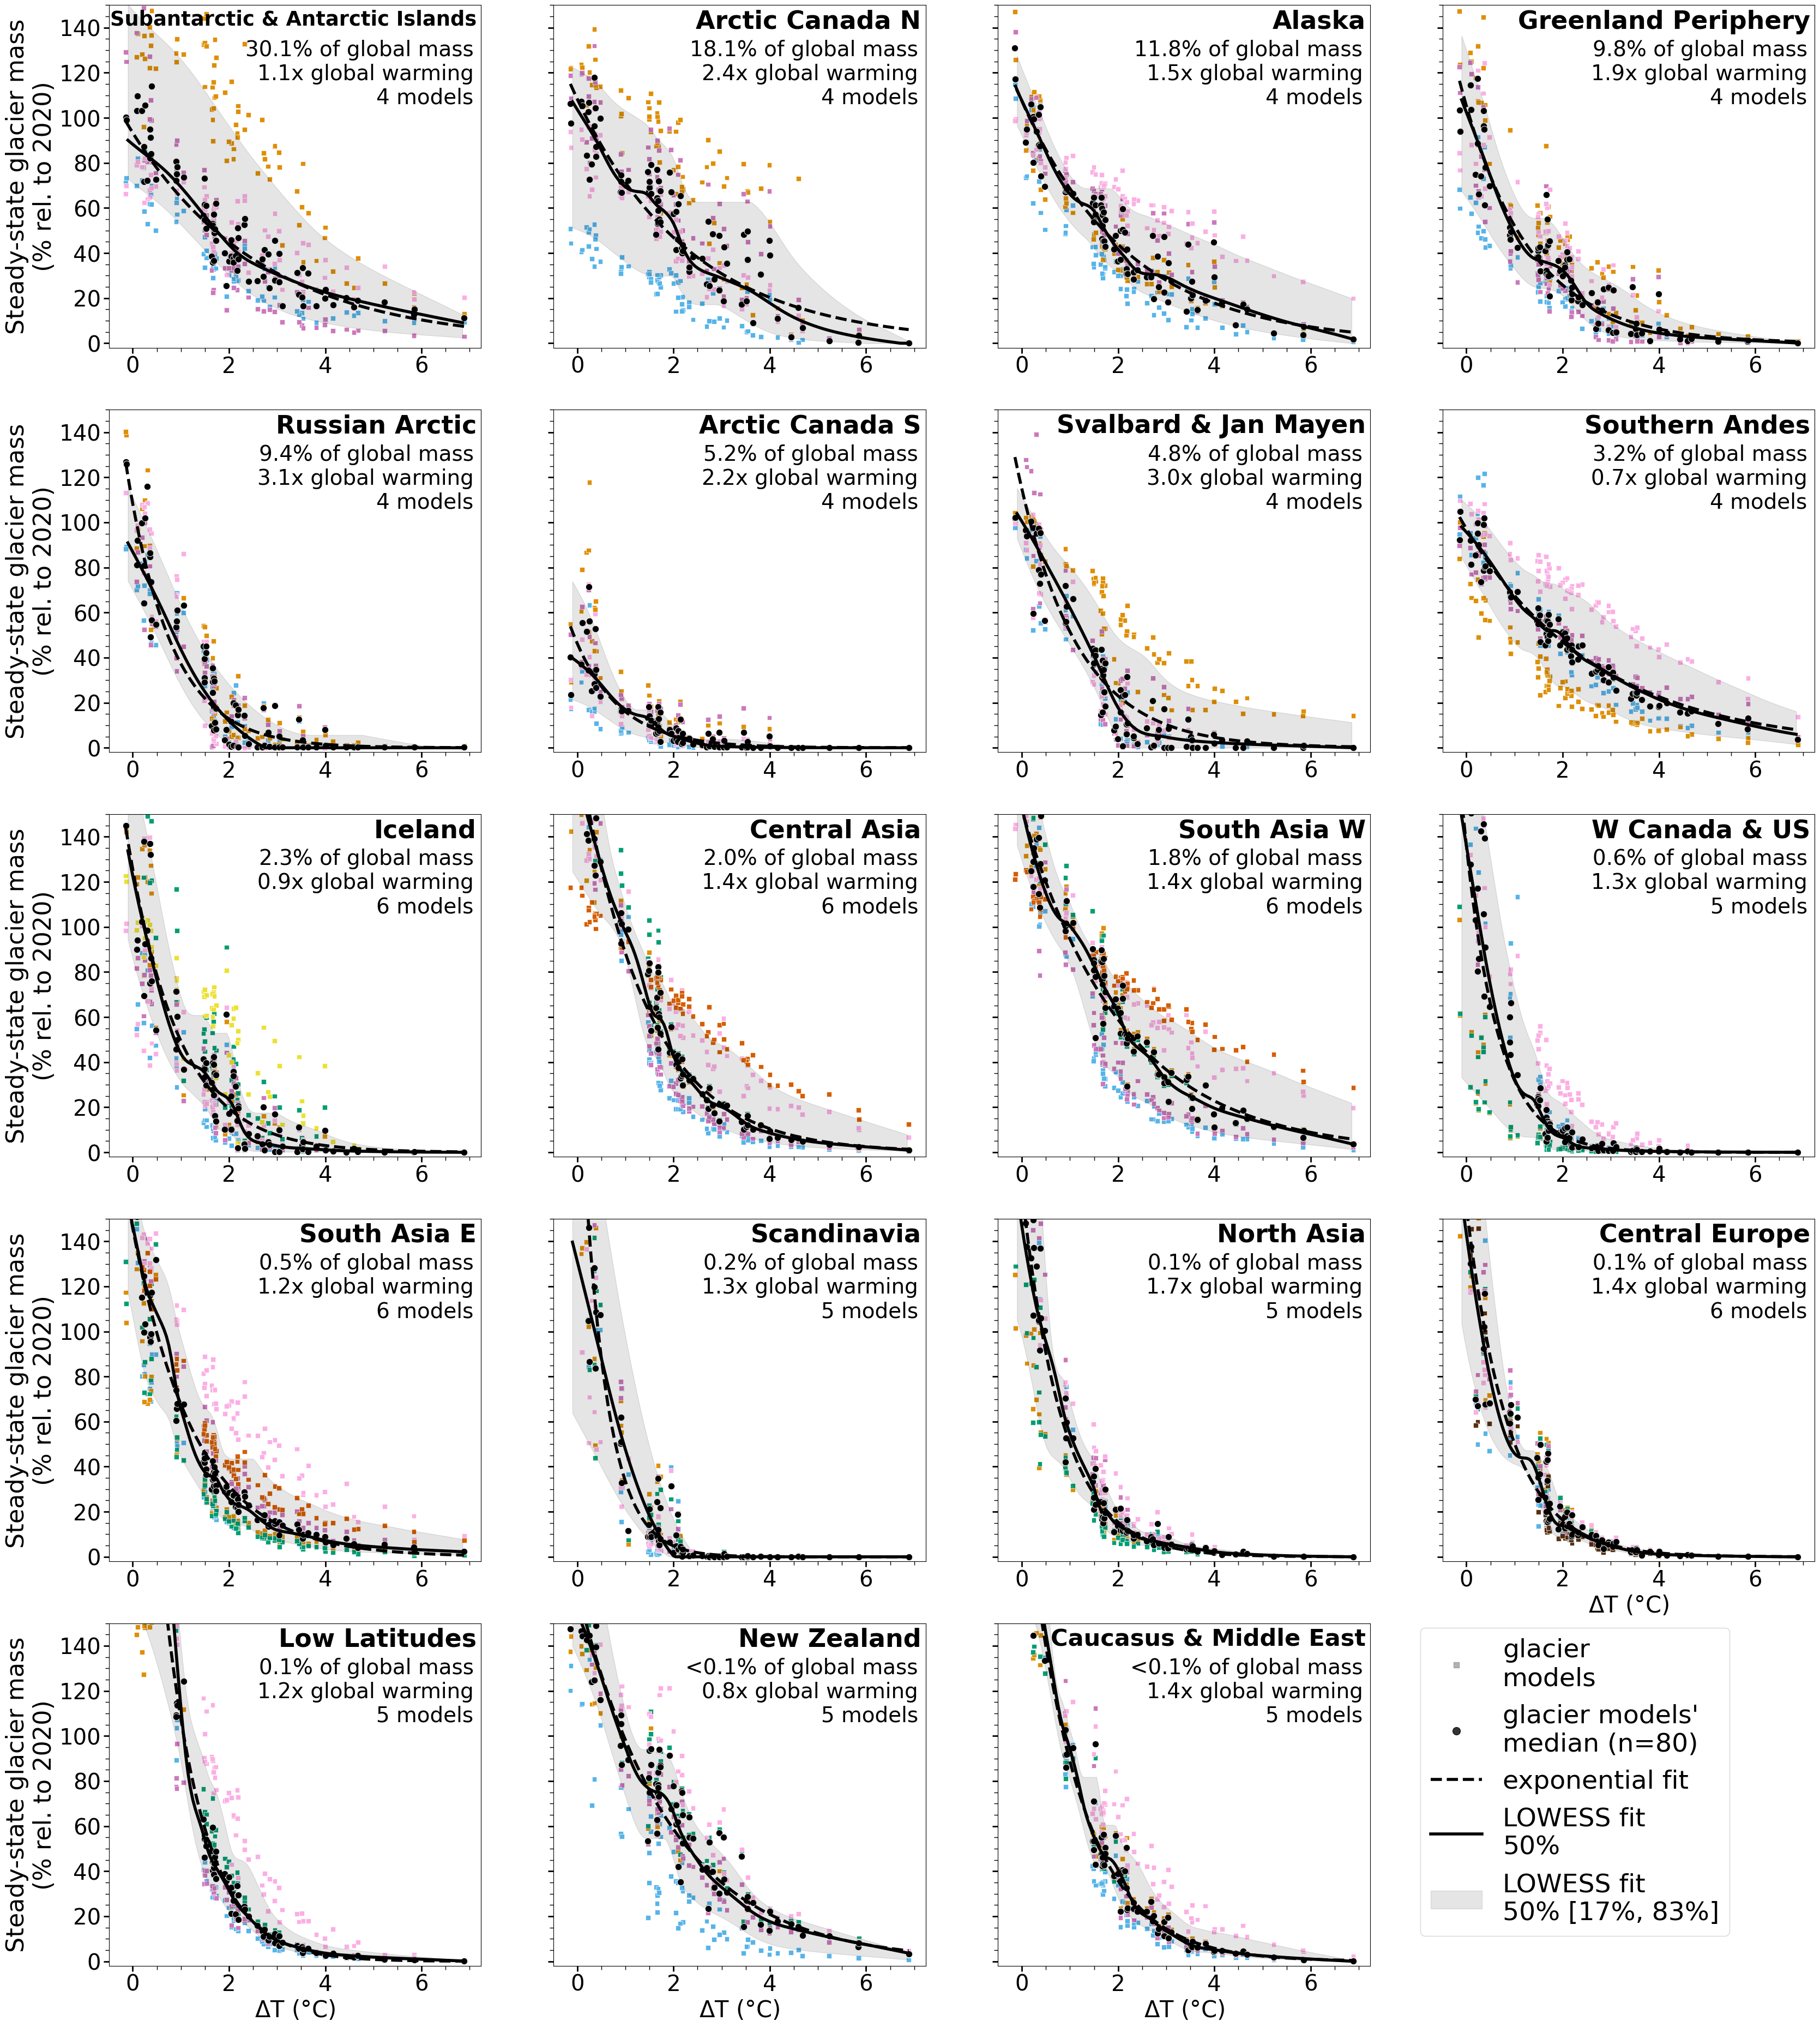

In [32]:
#ylim1 = 600 #
ylim1 = 150 #150 #suppl. fig. ... 
show_models_in_grey = False
fig_reg_temp_fit  = False   #now extended data Fig. S3...  (lowess fit vs regional temp. change )-> use
# volume change vs regional temp. change:  median, lowess fit but not quantiles shown because ...
# if globally, the median comes from all estimates (also from those models that are only available for some RGI regions ...)
# but it is the median over the experiments, so it should be ok, to do that, 
# the lowess fit for the median is also done over these medians (80 exps.) separately (rel. to global glacier-area temp., so 
# there the fit is ok to have (but not the uncertainties, as those are, at the moment coming directly from the sum of the exps)
fig_s_only_global_models = False  # Now Fig. S10only global models ... 
only_90perc = True
#### PROBLEM HERE --> THE GLOBAL MODEL has not been fitted with the regional sums, probably it is best to just simplify the figure and to just show the global figure with the fit using all data ... instead .... TODO ... 
############## 
temp_ch = ''
show_color_models = True
current_deltaT = 1.2

f_path = '../A_community_estimate_paper_analysis/'
shift_years = True
if shift_years:
    p_shift = '_shift_years_rel_2020'
else:
    p_shift = ''
f_path_f = f'{f_path}figures/'

temp_above_0_8 = False
add_lowess =True
  
def exponential_decay(x, a, b):
    # avoind overflow -> does not work ... 
    exp_values = -b * x
    #exp_values = np.clip(exp_values, -709, 709)  # Clip values to avoid overflow
    return a * np.exp(exp_values) #+ c * np.exp(-d * x**2)#**c 
param_bounds = ([0, 0], [1000, 5])

remove_local_minima = True
#qs = [0.05,0.25,0.5,0.75,0.95]
qs = [0.17,0.5,0.83]

#if  only_90perc:
# qs = [0.05,0.5,0.95]
#sim_years = [100, 5000] # 
#sim_years = [50, 100,300,500, 5000]
sim_years = [5000, 100, 500] # to add 100, 
#ylim1 = 600
#sim_years = [5000]
# condition for Fig2 

if fig_reg_temp_fit:
    sim_years = [5000] # only have that computed
    temp_ch = 'regional_glacier'
else:
    temp_ch = ''
    
if ylim1>150:
    sim_years = [5000]
    
##########
if fig_s_only_global_models:
    path_only_glob = '_only_global_models'
    sim_years = [5000] # only have that computed
else:
    path_only_glob = ''

fig_count = 0     
for sim_year in sim_years:  #[5000]: #sim_years: #sim_years: # 
    print(sim_year)
    if (ylim1 == 150) and (sim_year == 5000) and (temp_ch=='') and (not fig_s_only_global_models):
        print('plot_fig2')
        plot_fig2=True
        show_leg2_in_subplot = False
        show_text = False
    else:
        show_leg2_in_subplot = True
        plot_fig2 = False
        show_text = True

    
    if show_text:
        plt.rc('font', size=27)  
    else:
        plt.rc('font', size=29)
    condis_suppl2 = (sim_year<5000) or (ylim1>150) or (path_only_glob == '_only_global_models') or (temp_ch== 'regional_glacier')
    sel_l = []
    df_quantiles_l = []
    if sim_year==5000:
        _sim_year = 'steady_state'
    else:
        _sim_year= f'after{sim_year}yr'
    if sim_year<5000:
        avg_over = '21yr'
    else:
        avg_over = '101yr'
        
    if condis_suppl2:     
        rgi_regs_sel = ['All'] + list(rgi_regs_sel_sorted_vol) #rgi_regs_global_r
    else:
        # do not include the global plot in Fig. 2!!!
        rgi_regs_sel = rgi_regs_sel_sorted_vol #rgi_regs_global_r[:-1]
    if temp_above_0_8:
        add= '_temp_above_0_8'
    else:
        add = ''

    if fit_to_median:
        add = add + '_fit_to_median'
    if add_lowess:
        add = add + '_lowess_added'
    if len(qs)>1:
        add = add + '_quantiles_added'
    if remove_local_minima:
        addi = add + '_removed_local_minima'
    ### read the fitted stuff 
    if temp_ch != 'regional_glacier':
        pd_sel = pd.read_csv(f'../data/lowess_fit_rel_2020_{avg_over}_avg_{_sim_year}_{DATE}{path_only_glob}.csv', index_col=[0])
    else:
        pd_sel = pd.read_csv(f'../data/lowess_fit_rel_2020_{avg_over}_avg_{_sim_year}_{DATE}{path_only_glob}_rel_{temp_ch}_temp_ch.csv', index_col=[0])
    pd_sel.index = pd_sel.temp_ch
    pd_sel.index = pd_sel.index.values.round(2)  
    assert pd_sel.year.unique() == sim_year
    # aggregate regional quantiles to get global quantile estimate 
    # for the median, we do the fit directly using the individual median fits 

    if avg_over=='101yr':
        sim_year_avg = 101
    elif avg_over=='21yr':
        sim_year_avg = 21
    else:
        raise InvalidParamsError
    #fig, axs = plt.subplots(5,4,figsize=(36,38), sharey=True) #, sharey='row') #, sharex=True)
    fig, axs = plt.subplots(5,4,figsize=(34.5,38), sharey=True) #, sharey='row') #, sharex=True)

    if path_only_glob != '_only_global_models':
        if shift_years:
            ds_reg_models_med_vol_roll = ds_reg_yr_shift_vol_med.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
            ds_reg_models_vol_roll = ds_reg_yr_shift_vol.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
        else:
            ds_reg_models_med_vol_roll = ds_reg_models_med_vol.rolling(simulation_year=sim_year_avg, center=True).mean().dropna(dim='simulation_year', how='all').sel(simulation_year=slice(0,sim_year))
            ds_reg_models_vol_roll = ds_reg_models_vol.rolling(simulation_year=sim_year_avg, center=True).mean().dropna(dim='simulation_year', how='all').sel(simulation_year=slice(0,sim_year))
    else:
        # only global models !!! 
        ds_reg_models_med_vol_global = ds_reg_yr_shift_vol.dropna(dim='model_author', how='any').median(dim='model_author')
        ds_reg_models_med_vol_roll = ds_reg_models_med_vol_global.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
        ds_reg_models_vol_roll = ds_reg_yr_shift_vol.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
        ds_reg_models_vol_roll = ds_reg_models_vol_roll.dropna(dim='model_author', how='any')
        #pd_quantiles_concat_g = pd.read_csv(f'{f_path}lowess_fits/fitted_lowess{p_shift}_{avg_over}_avg_period{add}_fit_over_global_estimates_current12deg_{sim_year}_{DATE}{path_only_glob}.csv', index_col=[0])
        #pd_sel_g = pd.read_csv(f'{f_path}lowess_fits/fitted_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_fit_over_global_estimates_current12deg_{sim_year}_{DATE}{path_only_glob}.csv', index_col=[0])
    
    for j, rgi_reg in enumerate(rgi_regs_sel):
        if j<4:
            ax = axs[0][j]
        elif j <8:
            ax = axs[1][j-4]
        elif j <12:
            ax = axs[2][j-8]
        elif j <16:
            ax = axs[3][j-12]
        elif j <20:
            ax = axs[4][j-16]
        if j == 17:
            plt.tight_layout()
        if rgi_reg == 'All':
            s_l = 'global'
            s_u = 'Global'
        else:
            s_l = 'regional'
            s_u = 'Regional'
        if sim_year==5000:
            v_n = r'$V_{\%,ss}$'
            state = f'Steady-state glacier mass' # {s_l} 
        elif sim_year == 50:
            v_n = r'$V_{\%,50yr}$'
            state = f'Glacier mass after 50 years' #{s_u} 
        elif sim_year == 100:
            v_n = r'$V_{\%,100yr}$'
            state = f'Glacier mass after 100 years'
        elif sim_year == 300:
            v_n = r'$V_{\%,300yr}$'
            state = f'Glacier mass after 300 years'
        elif sim_year ==500:
            v_n = r'$V_{\%,500yr}$'
            state = f'Glacier mass after 500 years'
        if ((temp_ch != 'regional_glacier') and  j <=1) or ((temp_ch == 'regional_glacier') and (j ==0)): # or (j == 0)): # or 
            _show_leg2_in_subplot = show_leg2_in_subplot
            print(rgi_reg, j, show_leg2_in_subplot)
        else:
            _show_leg2_in_subplot = False
        func_subplot_warming_scatter(ax, rgi_reg=rgi_reg, show_leg2_in_subplot=_show_leg2_in_subplot, path_only_glob=path_only_glob,
                                    pd_sel=pd_sel) #, approach = approach, temp_ch
        if plot_fig2: 
            perc_glob = pd_hugo_far_reg.loc[rgi_reg]['%_2020_rel_global'].round(1)
            pd_global_temp_exp_m = get_glob_temp_exp(region='global')

            if rgi_reg == 'All':
                region = 'global_glacier'
            else:
                region = f'RGI{rgi_reg}_glacier'
            pd_global_temp_exp_m_glac = get_glob_temp_exp(region=region)
            pd_global_temp_exp_m.loc[pd_global_temp_exp_m_glac.index, 'temp_ch_ipcc_glacier'] = pd_global_temp_exp_m_glac['temp_ch_ipcc'].values
            pd_t = pd_global_temp_exp_m
            # compute ratio from difference to 1986-2005 
            # from 1850 to 1986-2005, we assumed a warming of 0.69°C for all regions equally, now we substract that again,
            # to have a better comparison 
            ratio = np.median((pd_t['temp_ch_ipcc_glacier'].values-0.69)/(pd_t['temp_ch_ipcc'].values-0.69)).round(1)
            if perc_glob==0:
                text_n =  f'<0.1% of global mass'  ##  in 2020
            else:
                text_n =  f'{perc_glob}% of global mass'  ##  in 2020
            text_n = text_n + f'\n{ratio}x global warming'

            ax.text(0.98, 0.9, text_n, horizontalalignment='right', 
                    verticalalignment='top', transform=ax.transAxes, fontsize=28)
        ax.tick_params(axis='both', which='major', width=2, length=7)
        ax.tick_params(axis='both', which='minor', width=1, length=5)
        minorx_locator = MultipleLocator(1)  # 1° difference 
        ax.xaxis.set_minor_locator(minorx_locator)
        minory_locator = MultipleLocator(10)  # 1° difference 
        ax.yaxis.set_minor_locator(minory_locator)
        ax.minorticks_on()


    if not condis_suppl2:
        axs[4][3].set_axis_off()
        # add manually after the tight_layout the xlabel from specific subplot
        if temp_ch == 'regional_glacier':
            #axs[3][3].set_xlabel(r'$\Delta$T$_{reg,glacier-area}$ (°C, compared to pre-industrial)', fontsize=30)
            axs[3][3].set_xlabel(r'$\Delta$T$_{g}$ (°C)', fontsize=30)

        else:
            #axs[3][3].set_xlabel(r'$\Delta$T$_{global}$ (°C, compared to pre-industrial)')
            axs[3][3].set_xlabel(r'$\Delta$T (°C)', fontsize=30)
    if ylim1 == 600:
        addi = addi + '_ylim600'
    addi = addi + path_only_glob
    if show_models_in_grey:
        a = '_show_models_in_grey'
    else:
        a = ''
    if (temp_ch == '') and (sim_year==5000) and (path_only_glob != '_only_global_models'):
        plt.savefig(f'{f_path_f}fig2.png')
        plt.savefig(f'{f_path_f}fig2.pdf')
    else:
        if temp_ch != 'regional_glacier':
            plt.savefig(f'{f_path_f}supplements/suppl_2_glacier_volume_yr_simple{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{addi}_current12deg_{DATE}{a}.png')
            plt.savefig(f'{f_path_f}supplements/suppl_2_glacier_volume_yr_simple{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{addi}_current12deg_{DATE}{a}.pdf')
        else:
            plt.savefig(f'{f_path_f}extended_data/fig_ED2.png')
            plt.savefig(f'{f_path_f}extended_data/fig_ED2.pdf')
            #plt.savefig(f'{f_path_f}supplements/suppl_2_glacier_volume_yr_simple{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{addi}_current12deg_reg_glacier_temp_ch_{DATE}{a}.png')
            #plt.savefig(f'{f_path_f}supplements/suppl_2_glacier_volume_yr_simple{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{addi}_current12deg_reg_glacier_temp_ch_{DATE}{a}.pdf')
    if fig_count !=0:
        plt.close()
    fig_count +=1

temp_ch = ''


**here are some global warming sampling statistics**

In [27]:
pd_global_temp_exp_m = get_glob_temp_exp(region='global')

ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.sum(dim='rgi_reg')

ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.assign_coords(temp_ch_ipcc = ('experiments',
                                                                          pd_global_temp_exp_m.loc[ds_reg_models_med_vol_sel.experiments, # make sure thatwe use the same experiments pd_global_temp_exp_m_glac
                                                                                                 'temp_ch_ipcc']))

print('how many experiments exist for which warming level exist (range, exp., mean over all exps, median)')
for deltaT in [0.0,1.2, #1.2, 1.2 is just too unclear ... 
               1.5,2.0,3.0,4.0]:
    print(f'warming level: {deltaT}°C')
    #deltaT = deltaT+0.06
    for t_range in [0.1,0.15,0.2,0.25]:

        _deltaT_sel = ds_reg_models_med_vol_sel.where((ds_reg_models_med_vol_sel.temp_ch_ipcc>deltaT-t_range) & (ds_reg_models_med_vol_sel.temp_ch_ipcc<deltaT+t_range)).dropna(dim='experiments')
        n_deltaT=len(_deltaT_sel.experiments)
        print(t_range, n_deltaT, _deltaT_sel.temp_ch_ipcc.mean().values, _deltaT_sel.temp_ch_ipcc.median().values)
    print('\n')

how many experiments exist for which warming level exist (range, exp., mean over all exps, median)
warming level: 0.0°C
0.1 1 0.0833736138284337 0.0833736138284337
0.15 4 -0.022603058526020653 -0.0242698559363759
0.2 5 0.020107092206236098 0.0833736138284337
0.25 7 0.08133789653078531 0.1016562514146834


warming level: 1.2°C
0.1 0 nan nan
0.15 1 1.0587674077643272 1.0587674077643272
0.2 1 1.0587674077643272 1.0587674077643272
0.25 1 1.0587674077643272 1.0587674077643272


warming level: 1.5°C
0.1 6 1.5005588835852863 1.4937853470539566
0.15 7 1.520009755362956 1.493791625332881
0.2 14 1.5970631102397388 1.6467728177590986
0.25 17 1.618867764670455 1.6599956464695365


warming level: 2.0°C
0.1 7 2.019770516027029 2.049075466844948
0.15 8 2.0347557546538537 2.0493414991684658
0.2 12 2.0838111906835044 2.0919714736555246
0.25 12 2.0838111906835044 2.0919714736555246


warming level: 3.0°C
0.1 4 2.997085254332482 2.9949774078721156
0.15 5 3.0187908528562923 3.038482494458876
0.2 7 2.96457

***Ok, we just chose +/-0.2°C for now**

**Here is the plot that highlights more  the median experiments over specific warming levels...**

In [29]:
def get_vol_timeseries_temp_ch_Xyr_glob_glacier_portrait(region='global', perc=90, sim_year=500, avg_over = '3yr', smooth_values_percentiles=1,
                                                         exp_decay_temp_fit=True,
                                                         temp_above_0_8=True, landscape = True, current_deltaT = 1.2,
                                                         shift_years = False, show_slope_fit = True,
                                                         show_old_b = False, show_min_max_quantiles_a = False,
                                                         complex_aggregation_scheme = True, # we still apply this manually here!
                                                         select_opt=''): 
    
    agg_reg_list = [['01', '03', '04', '05', '07', '09', '17', '19'],['02', '08', '10', '12', '16', '18'], ['13', '14', '15'], ['06'], ['11']]
    remove_subplot_c = True

    path_only_glob = ''    
    temp_ch = ''

    if shift_years and exp_decay_temp_fit:
        raise NotImplementedError
    if avg_over=='101yr':
        avg_yr_int = 101
    elif avg_over=='60yr':
        avg_yr_int = 60
    elif avg_over=='21yr':
        avg_yr_int = 21
    elif avg_over=='20yr':
        avg_yr_int = 20
    elif avg_over =='3yr':
        avg_yr_int = 3


    if temp_above_0_8:
        add= '_temp_above_0_8'
    else:
        add = ''
    if shift_years:
        p_shift = '_shift_years_rel_2020'
        xx = 'year_after_2020'
    else:
        p_shift = ''
        xx = 'simulation_year'
    

    if shift_years:
        ds_reg_models_med_vol_roll = ds_reg_yr_shift_vol_med.rolling(year_after_2020=avg_yr_int, center=True,
                                        min_periods=1).mean().dropna(dim='year_after_2020', how='all') #int(avg_yr_int/2+1)
        _ds_reg_models_vol = ds_reg_yr_shift_vol

    else:
        ds_reg_models_med_vol_roll = ds_reg_models_med_vol.rolling(simulation_year=avg_yr_int, center=True, min_periods=1).mean().dropna(dim='simulation_year', how='all')
        _ds_reg_models_vol = ds_reg_models_vol
    #.sel(simulation_year=slice(0,sim_year))

    q1=(50-perc/2)/100
    q2=(50+perc/2)/100


    plt.rc('font', size=25)  
    if not show_old_b:
        if remove_subplot_c:
            fig_cols = 2
        else:
            fig_cols = 3
        if landscape:
            fig,axs= plt.subplots(1,fig_cols,figsize=(27,11.5))
            add = add+'_landscape'

        else:
            fig,axs= plt.subplots(fig_cols,1,figsize=(12,34))
    else:
        if landscape:
            fig,axs= plt.subplots(1,2,figsize=(25,10))
            add = add+'_landscape'

        else:
            fig,axs= plt.subplots(2,1,figsize=(12,20))

    ax = axs[0]
    # get global temp. change
    pd_global_temp_exp_m = get_glob_temp_exp(region='global')

    if region == 'global':
        # get global glacier temp.change
        pd_global_temp_exp_m_glac = get_glob_temp_exp(region='global_glacier')
        ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.sum(dim='rgi_reg')
        n_models = ''
        rgi_reg = 'global'
        rgi_reg_f = 'All'

        # ATTENTION: the initial volume should not be estimated from the rolling average
        if shift_years:
            init_vol = pd_rgi_stats_w_hugonnet.loc['All'][f'regional_volume_m3_2020{approach}']
        else:
            init_vol = ds_reg_models_med_vol.isel(simulation_year=0).sum(dim='rgi_reg').values[0]
    else:
        # get regional glacier temp. change
        pd_global_temp_exp_m_glac = get_glob_temp_exp(region=region)
        rgi_reg = region[3:5]
        rgi_reg_f = rgi_reg
        ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.sel(rgi_reg=rgi_reg)
        # check how many glacier models have at least some estimates
        reg_glac_models = ds_reg_models.sel(rgi_reg=rgi_reg).dropna(dim='model_author', how='all').model_author
        print(reg_glac_models.values)
        n_models = len(reg_glac_models)
        n_models = f'{n_models} '
        # ATTENTION: the initial volume should not be estimated from the rolling average, or???
        if shift_years:
            init_vol = pd_rgi_stats_w_hugonnet.loc[rgi_reg][f'regional_volume_m3_2020{approach}']
        else:
            init_vol = ds_reg_models_med_vol.isel(simulation_year=0).sel(rgi_reg=rgi_reg).values[0]


    ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.assign_coords(temp_ch_ipcc = ('experiments',
                                                                          pd_global_temp_exp_m.loc[ds_reg_models_med_vol_sel.experiments, # make sure thatwe use the same experiments pd_global_temp_exp_m_glac
                                                                                                 'temp_ch_ipcc']))

    ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.assign_coords(temp_ch_ipcc_glacier = ('experiments',
                                                                          pd_global_temp_exp_m_glac.loc[ds_reg_models_med_vol_sel.experiments, # make sure thatwe use the same experiments pd_global_temp_exp_m_glac
                                                                                                 'temp_ch_ipcc']))


    # need that to have both volume_m3 and temp_ch_ipcc as variables
    ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.reset_coords()
    ds_reg_models_med_vol_sel['relative volume change (in %)'] = 100*ds_reg_models_med_vol_sel.volume_m3/init_vol
    #print(ds_reg_models_med_vol_sel)
    pd_t =ds_reg_models_med_vol_sel.to_dataframe()
    try:
        pd_t = pd_t.drop(columns=['gcm','period_scenario'])
    except:
        pass
    pd_t = pd_t.reset_index()
    #pd_t['volume (km3)'] = pd_t['volume_m3']/1e9
    
    # due to the colorscale issue, I prefer to do a for-loop, to really be sure to have the right color:
    data_all = pd_t.loc[pd_t[xx]<sim_year]
    
    for t in pd_t['temp_ch_ipcc'].unique():
        data = data_all.loc[data_all.temp_ch_ipcc == t]
        c=cmap(scaler.transform(np.array(t).reshape(-1,1))).squeeze()
        ax.plot(data[xx], data['relative volume change (in %)'], color=c,
                 lw=0.7, alpha =0.8)
        if t == pd_t['temp_ch_ipcc'].unique()[0]:
            c0 = c
        elif t == pd_t['temp_ch_ipcc'].unique()[-1]:
            c1 = c
            
    # plot specific delta T:
    col_temp_l = []
    exp_l = []
    deltaT_sel_l = []
    for deltaT in [0.0,#1.2, for 1.2 there are no real experiments nearby ... 
                   1.5,2.0,3.0,4.0]:

        t_range = 0.2 
        if select_opt=='nearest':
            exp_sel = np.abs(ds_reg_models_med_vol_sel.temp_ch_ipcc - deltaT).idxmin()
            _deltaT_sel = ds_reg_models_med_vol_sel.sel(experiments = exp_sel)
            n_deltaT =1
        else:
            _deltaT_sel = ds_reg_models_med_vol_sel.where((ds_reg_models_med_vol_sel.temp_ch_ipcc>deltaT-t_range) & 
                                                      (ds_reg_models_med_vol_sel.temp_ch_ipcc<deltaT+t_range)).dropna(dim='experiments')
            n_deltaT=len(_deltaT_sel.experiments)
            _deltaT_sel = _deltaT_sel.mean(dim='experiments')
        print(deltaT, n_deltaT, _deltaT_sel.temp_ch_ipcc.mean().values)
        # even if it is only roughly matched, we prefer to label it to 0,1.5,2,3,4 ... 
        _deltaT_sel['temp_ch_ipcc'] = deltaT
        col_temp=cmap(scaler.transform(np.array(deltaT).reshape(-1,1))).squeeze()

        col_temp_l.append(col_temp)
        deltaT_sel_l.append(_deltaT_sel)
        if shift_years:
            vals = _deltaT_sel['relative volume change (in %)'].isel(year_after_2020=-1).values
        else:
            vals = _deltaT_sel['relative volume change (in %)'].isel(simulation_year=-1).values
        print(vals)
        ax.text(sim_year+1,vals,
                f'{deltaT:.1f}°C', color=col_temp,
                va='center',
               fontsize=21)


    pd_t_sel = xr.concat(deltaT_sel_l, dim='temp_ch_ipcc').to_dataframe()

    pd_t_sel = pd_t_sel.reset_index()
    # due to the colorscale issue, I prefer to do a for-loop, to really be sure to have the right color:
    data_all = pd_t_sel.loc[pd_t_sel[xx]<sim_year]
    
    for t in pd_t_sel['temp_ch_ipcc'].unique():
        data = data_all.loc[data_all.temp_ch_ipcc == t]
        c=cmap(scaler.transform(np.array(t).reshape(-1,1))).squeeze()
        ax.plot(data[xx], data['relative volume change (in %)'], color=c,
                 lw=5, ls ='--')
    
    if show_min_max_quantiles_a:
        exp_temp_min = np.array([ds_reg_models_med_vol_sel.temp_ch_ipcc.idxmin()])
    else:
        deltaT = 0  
        if select_opt=='nearest':
            exp_temp_min = np.abs(ds_reg_models_med_vol_sel.temp_ch_ipcc - deltaT).idxmin()
            #_deltaT_sel = ds_reg_models_med_vol_sel.sel(experiments = exp_sel)
            qdims = ['model_author']
        else:
            t_range = 0.2
            condi = (ds_reg_models_med_vol_sel.temp_ch_ipcc>deltaT-t_range) & (ds_reg_models_med_vol_sel.temp_ch_ipcc<deltaT+t_range)
            exp_temp_min = ds_reg_models_med_vol_sel.temp_ch_ipcc.where(condi).dropna(dim='experiments').experiments
            qdims = ['model_author','experiments']
        print(exp_temp_min.values)

    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    if complex_aggregation_scheme and region == 'global':
        if shift_years:
            _t_l = []
            for agg in agg_reg_list:
                _t_l.append(_ds_reg_models_vol.sel(rgi_reg=agg).dropna(dim='model_author').sum(dim='rgi_reg').rolling(year_after_2020=avg_yr_int,
                                                         center=True).mean().dropna(dim='year_after_2020',
                                                                                    how='all').sel(experiments=exp_temp_min).quantile([q1,q2], dim=qdims).sel(year_after_2020=slice(0,sim_year)))
            q1_2_min_glob = xr.concat(_t_l, dim='reg_agg').sum(dim='reg_agg')
            print(region, q1_2_min_glob.isel(year_after_2020=-1).values)

        else:
            raise NotImplementedError
    else:
        if shift_years:
            q1_2_min = _ds_reg_models_vol.rolling(year_after_2020=avg_yr_int,
                                                 center=True).mean().dropna(dim='year_after_2020',
                                                                            how='all').sel(experiments=exp_temp_min).quantile([q1,q2],
                                                                                                                              dim=qdims).sel(year_after_2020=slice(0,sim_year))
        else:
            q1_2_min = _ds_reg_models_vol.rolling(simulation_year=avg_yr_int,
                                                 center=True).mean().dropna(dim='simulation_year',
                                                                            how='all').sel(experiments=exp_temp_min).quantile([q1,q2],
                                                                                                                              dim=qdims).sel(simulation_year=slice(0,sim_year))
    if region == 'global':
        if not complex_aggregation_scheme:
            q1_2_min_glob = q1_2_min.sum(dim='rgi_reg')
        if shift_years:
            # here it does not matter as all models start at the same... 
            q1_2_min_init = _ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([q1,q2],dim=qdims).isel(year_after_2020=0).sum(dim='rgi_reg')
        else:
            q1_2_min_init = _ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([q1,q2],dim=qdims).isel(simulation_year=0).sum(dim='rgi_reg')

    else:
        q1_2_min_glob = q1_2_min.sel(rgi_reg=rgi_reg)
        if shift_years:
            q1_2_min_init = _ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([q1,q2], dim=qdims).isel(year_after_2020=0).sel(rgi_reg=rgi_reg)
        else:
            q1_2_min_init = _ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([q1,q2], dim=qdims).isel(simulation_year=0).sel(rgi_reg=rgi_reg)

    # do not divide by minimum, but by init_vol!!!
    # q1_2_min_glob = (100*q1_2_min_glob/q1_2_min_init)
    q1_2_min_glob = (100*q1_2_min_glob/init_vol)
    

    ax.fill_between(q1_2_min_glob[xx],
             q1_2_min_glob.sel(quantile=q1), q1_2_min_glob.sel(quantile=q2), alpha = 0.1, color=c0, zorder=0)
    #handles, labels = ax.get_legend_handles_labels()
    #t = plt.legend(handles, labels)
    #ax.add_artist(leg)
    if show_min_max_quantiles_a:
        exp_temp_max = [ds_reg_models_med_vol_sel.temp_ch_ipcc.idxmax()]
    else:
        deltaT = 4    
        if select_opt == 'nearest':
            exp_temp_max = np.abs(ds_reg_models_med_vol_sel.temp_ch_ipcc - deltaT).idxmin()
            #_deltaT_sel = ds_reg_models_med_vol_sel.sel(experiments = exp_sel)
            qdims = ['model_author']
        else:
            t_range = 0.2
            condi = (ds_reg_models_med_vol_sel.temp_ch_ipcc>deltaT-t_range) & (ds_reg_models_med_vol_sel.temp_ch_ipcc<deltaT+t_range)
            exp_temp_max = ds_reg_models_med_vol_sel.temp_ch_ipcc.where(condi).dropna(dim='experiments').experiments
            qdims = ['model_author','experiments']
        #print(exp_temp_max.values)
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    if complex_aggregation_scheme and region == 'global':
        if shift_years:
            _t_l = []
            for agg in agg_reg_list:
                _t_l.append(_ds_reg_models_vol.sel(rgi_reg=agg).dropna(dim='model_author').sum(dim='rgi_reg').rolling(year_after_2020=avg_yr_int,
                                                         center=True).mean().dropna(dim='year_after_2020',
                                                                                    how='all').sel(experiments=exp_temp_max).quantile([q1,q2], dim=qdims).sel(year_after_2020=slice(0,sim_year)))
            q1_2_max_glob = xr.concat(_t_l, dim='reg_agg').sum(dim='reg_agg')
            print(region, q1_2_max_glob.isel(year_after_2020=-1).values)
        else:
            raise NotImplementedError
    else:
        if shift_years:
            q1_2_max = _ds_reg_models_vol.rolling(year_after_2020=avg_yr_int,
                                             center=True).mean().dropna(dim='year_after_2020', how='all').sel(experiments=exp_temp_max).quantile([q1,q2],
                                             dim=qdims).sel(year_after_2020=slice(0,sim_year))
        else:
            q1_2_max = _ds_reg_models_vol.rolling(simulation_year=avg_yr_int,
                                             center=True).mean().dropna(dim='simulation_year', how='all').sel(experiments=exp_temp_max).quantile([q1,q2],
                                             dim=qdims).sel(simulation_year=slice(0,sim_year))
    if region == 'global':
        if not complex_aggregation_scheme:
            q1_2_max_glob = q1_2_max.sum(dim='rgi_reg')
        if shift_years:
            q1_2_max_init =_ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([q1,q2], dim=qdims).isel(year_after_2020=0).sum(dim='rgi_reg')    
        else:
            q1_2_max_init =_ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([q1,q2],dim=qdims).isel(simulation_year=0).sum(dim='rgi_reg')
    else:
        q1_2_max_glob = q1_2_max.sel(rgi_reg=rgi_reg)
        if shift_years:
            q1_2_max_init =_ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([q1,q2], dim=qdims).isel(year_after_2020=0).sel(rgi_reg=rgi_reg)
        else:
            q1_2_max_init =_ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([q1,q2], dim=qdims).isel(simulation_year=0).sel(rgi_reg=rgi_reg)

    # do not divide by minimum, but by init_vol!!!
    # q1_2_max_glob = (100*q1_2_max_glob/q1_2_min_init)
    q1_2_max_glob = (100*q1_2_max_glob/init_vol)
    
    #print( q1_2_min_glob, q1_2_max_glob)
    ax.fill_between(q1_2_max_glob[xx],
             q1_2_max_glob.sel(quantile=q1), q1_2_max_glob.sel(quantile=q2), alpha = 0.1, color=c1, zorder=0);
        
    if shift_years:
        ax.set_xlabel('Simulation year', # after 2020', (this is confusing (we just remove it 
                      fontsize=28)
        if region == 'global':
            ax.set_ylabel(f'Global glacier mass (% rel. to 2020)', fontsize=28) #, relative to initial state, {avg_yr_int}-yr average)')
        else:
            ax.set_ylabel(f'RGI{rgi_reg} glacier mass (% rel. to 2020)', fontsize=28) #, relative to initial state, {avg_yr_int}-yr average)')
    else:
        ax.set_xlabel('Simulation year')
        if region == 'global':
            ax.set_ylabel(f'Global glacier mass (% rel. to Farinotti)') #, relative to initial state, {avg_yr_int}-yr average)')
        else:
            ax.set_ylabel(f'RGI{rgi_reg} glacier mass (% rel. to Farinotti)') #, relative to initial state, {avg_yr_int}-yr average)')


    # add additional legend for glacier model uncertatinties and other things ... 
    #define patches and lines to add to legend
    #patch_min = mpatches.Patch(label=f'{perc}th %-ile minimum temperature',  alpha = 0.2, color=l.lines[0].get_color())
    if not show_min_max_quantiles_a:
        label_quantiles = f'for $\Delta$T=0.0°C & $\Delta$T=4.0°C'
    else:
        label_quantiles = 'for minimum & maximum '+r'$\Delta$T'
    if perc==100:
        patch_max = mpatches.Patch(label=f'range of glacier models\n{label_quantiles}',  alpha = 0.2, color='grey') # RH% removed total range
    else:
        if perc==66:
            patch_max = mpatches.Patch(label=f'likely range [17%, 83%]\n{label_quantiles}',  alpha = 0.2, color='grey')
        else:
            patch_max = mpatches.Patch(label=f'{perc}th %-ile of glacier models\n{label_quantiles}',  alpha = 0.2, color='grey')
    line1 = Line2D([0], [0], label=r"glacier models' median at $\Delta$T (n=80)", color='black', lw=1, alpha = 0.7)
    line2 = Line2D([0], [0], label=r'median at $\Delta$T$\pm$'+f'{t_range}°C', #\pm$0.25°C', %%% RH removed selected
                   color='black', lw=5, alpha = 0.8, ls = '--')
    #add handles
    handles= [line1, line2, patch_max]
    #add legend

    ax.legend(handles=handles, loc = 'upper left', #loc='upper left',
              bbox_to_anchor = (0.1,1),fontsize=24) #, bbox_to_anchor=(0.1,1))
    #ax.add_artist(leg)

    #if region == 'global':
    #    ax.set_title(f'Global glacier volume equilibration experiments')
    #else:
    #    ax.set_title(f'RGI{rgi_reg} glacier volume equilibration experiments')
    if sim_year == 2000:

        ax.set_xlim(-8, 2000*1.10)
        ax.set_xticks(np.arange(0,2150,500),np.arange(0,2150,500))
    elif sim_year == 500:
        ax.set_xlim(-2, 500*1.12)
        ax.set_xticks(np.arange(0,550,100),np.arange(0,550,100))
    else:
        ax.set_xlim(-20, 5000*1.12)
        ax.set_xticks(np.arange(0,5100,1000),np.arange(0,5100,1000))
        
    # ax.set_ylim([-1,165])
    for deltaT_t in ['min_t', 'max_t']:
        if deltaT_t == 'min_t':
            deltaT = ds_reg_models_med_vol_sel.temp_ch_ipcc.min().values
        else:
            deltaT = ds_reg_models_med_vol_sel.temp_ch_ipcc.max().values
        exp_sel = ds_reg_models_med_vol_sel.where(ds_reg_models_med_vol_sel.temp_ch_ipcc == deltaT).dropna(dim='experiments').experiments
        _deltaT_sel = ds_reg_models_med_vol_sel.sel(experiments = exp_sel)
        #print(deltaT, n_deltaT, _deltaT_sel.temp_ch_ipcc.mean().values)
        # even if it is only roughly matched, we prefer to label it to 0,1.5,2,3,4 ... 
        #_deltaT_sel['temp_ch_ipcc'] = deltaT
        col_temp=cmap(scaler.transform(np.array(deltaT).reshape(-1,1))).squeeze()
        if shift_years:
            vals = _deltaT_sel['relative volume change (in %)'].isel(year_after_2020=-1).values
        else:
            vals = _deltaT_sel['relative volume change (in %)'].isel(simulation_year=-1).values
        print(deltaT_t, exp_sel, _deltaT_sel, vals)

        ax.text(sim_year+1,vals,
                f'{deltaT:.1f}°C', color=col_temp,
                va='center',
               fontsize=19)
    if region == 'global':
        ax.set_ylim([0,160])
    ########################################### FIGURE 1b below#############################
    # from here on we look at 101 year averages
    avg_yr_int = 101
    sim_year=5000 # from here on we want to look into the 5000yr stuff!!! 
    ax=axs[1]
    if not show_old_b:
        # for steady state  the avg_over is 101!!! , and sim_year 5000
        ### read the fitted stuff 
        pd_sel = pd.read_csv(f'../data/lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}{path_only_glob}.csv', index_col=[0])
        pd_sel.index = pd_sel.temp_ch
        pd_sel.index = pd_sel.index.values.round(2)  
        func_subplot_warming_scatter(ax, rgi_reg=rgi_reg_f, fig_1b=True, show_leg2_in_subplot=False,  path_only_glob=path_only_glob,
                                    pd_sel=pd_sel) # here the complex aggregation scheme is applied automatically
        if show_slope_fit and shift_years:
            pd_lowess_fit_sel = pd_lowess_fit.loc[(pd_lowess_fit.region == rgi_reg_f) & (pd_lowess_fit.year==5000)]
            # globally, 2 %  can be saved for every tenth of a degree between 1.5 and 3°C !!!
            temp_sensitivity = (pd_lowess_fit_sel.loc[1.5]['0.5'] - pd_lowess_fit_sel.loc[3.0]['0.5'])/(3-1.5)/10 # every tenth of a degree
            temp_sensitivity = temp_sensitivity.round(1)
            #pd_t_sel_1o5_3 = pd_t.loc[(pd_t.temp_ch_ipcc>=1.5) & (pd_t.temp_ch_ipcc<=3)]
            #pd_t_sel_1o5_3 = pd_t_sel_1o5_3.loc[pd_t_sel_1o5_3[xx]==int(sim_year-avg_yr_int/2+1)]
            #slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_t_sel_1o5_3['temp_ch_ipcc'].values, pd_t_sel_1o5_3['relative volume change (in %)'])
            #ax.plot(pd_t_sel_1o5_3['temp_ch_ipcc'], slope*pd_t_sel_1o5_3['temp_ch_ipcc'].values + intercept, color = 'black', alpha = 0.7, lw=4)
            #ax.plot([1.5,3.0], [pd_lowess_fit_sel.loc[1.5]['0.5'], pd_lowess_fit_sel.loc[3.0]['0.5']], color = 'black', alpha = 0.7, lw=4)
            # 2.25 in the middle (as linear fit: pd_lowess_fit_sel.loc[1.5]['0.5']- (pd_lowess_fit_sel.loc[1.5]['0.5']-pd_lowess_fit_sel.loc[3.0]['0.5'])/2
            two_deg = pd_lowess_fit_sel.loc[2.25]['0.5'] #['0.5']- (pd_lowess_fit_sel.loc[1.5]['0.5']-pd_lowess_fit_sel.loc[3.0]['0.5'])/2 # pd_lowess_fit_sel.loc[2]['0.5']
            if rgi_reg not in ['01','04','03','05','14','17','19','13']: #global
                ax.text(1.51, 97, 
                        f'{temp_sensitivity}% additional\nmass loss for\nevery tenth of\ndegree global\nwarming',
                        va='bottom', ha = 'left', fontsize=24) #, arrowprops=dict(arrowstyle='<->', lw=2))
                ax.annotate('', #{temp_sensitivity}% additional\nmass loss for\nevery tenth of\ndegree global warming',
                            xy=(1.5, 95), xytext=(3.0, 95),
                            arrowprops=dict(arrowstyle='<->', lw=2), alpha = 0.8)
                #ax.annotate(f'{temp_sensitivity}% additional mass\nloss for every tenth of\ndegree global warming\n'+r'(in $\Delta$T=1.5-3.0°C range)',
                #            xy=(2.25,two_deg*1.05),xytext=(3.3,52),
                #            arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=0.3"), color='black',
                #            alpha=0.95, fontsize=26)
            elif rgi_reg in ['13']:
                ax.annotate(f'{temp_sensitivity}% additional mass\nloss for every tenth of\ndegree global warming\n'+r'(in $\Delta$T=1.5-3.0°C range)',
                            xy=(2.25,two_deg),xytext=(3.1,70),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=0.3"), color='black',
                            alpha=0.95, fontsize=24)
            else:
                ax.annotate(f'{temp_sensitivity}% additional mass\nloss for every tenth of\ndegree global warming\n'+r'(in $\Delta$T=1.5-3.0°C range)',
                            xy=(2.25,two_deg),xytext=(-0.4,-0.9),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=0.3"), color='black', 
                            alpha=0.95, fontsize=24)
        ax.set_xlabel(r'$\Delta$T (°C)', fontsize=28)
        if shift_years:
            sim_year=5000-50 # from here on we want to look into the 5000yr stuff!!! 
            if region == 'global':
                ax.set_ylabel(f'Steady-state global glacier mass\n(% rel. to 2020)', fontsize=28) #'\n(in %, relative to initial state, {avg_yr_int}-yr average)')
            else:
                ax.set_ylabel(f'Steady-state RGI{rgi_reg} glacier mass\n(% rel. to 2020)', fontsize=28) #\n(in %, relative to initial state, {avg_yr_int}-yr average)')
        else:
            if region == 'global':
                ax.set_ylabel(f'Steady-state global glacier mass (%)', fontsize=28) #'\n(in %, relative to initial state, {avg_yr_int}-yr average)')
            else:
                ax.set_ylabel(f'Steady-state RGI{rgi_reg} glacier mass (%)', fontsize=28) #\n(in %, relative to initial state, {avg_yr_int}-yr average)')
        ax0_ylim0, ax0_ylim1 = axs[0].get_ylim()
        ax.set_ylim([ax0_ylim0, ax0_ylim1])

        ## annotate 1.2°C
        fit_current = pd_lowess_fit_sel.loc[1.2]['0.5']
        ax.annotate(f'Current\nclimatic\nconditions\n(2014-2023):\n'+r'$\Delta$T=1.2°C',
                    fontsize=24,
                xy=(1.2, fit_current), xycoords='data',
                xytext=(-0.4, 1), textcoords='data',
                color='grey',
                arrowprops=dict(facecolor='grey', arrowstyle="->",lw=2, alpha = 0.6), #, connectionstyle="arc3, rad=0.3"
                horizontalalignment='left',
                verticalalignment='bottom')

            
    if region!='global':
        axs[0].set_ylim(axs[1].get_ylim())
    else:
        axs[1].set_ylim(axs[0].get_ylim())
    ################ 3rd inset subplot ##############
    #plt.tight_layout()
   

    # add a,b,c
    num_text_x = 0.007
    for j,axi in enumerate([axs[0],axs[1]]): # , inset_ax
        if j <2:
            num_text_y = 0.955
        else:
            num_text_y = 0.9
        axi.text(num_text_x, num_text_y,
                 num_dict[j], fontsize=30, transform=axi.transAxes)


    if region == 'global':
        for ax in axs[:2]:
            #ax.set_ylabel('Glacier volume (in %)')
            ax.set_yticks(np.arange(0,160,25),np.arange(0,160,25))
    for j,ax in enumerate(axs): 
        ax.minorticks_on()
        if j==1:
            ax.set_xticks(np.arange(0.5,6.9,1), minor=True)
        else:
            ax.set_xticks(np.arange(0,2000,100), minor=True)
        ax.tick_params(axis='both', which='major', width=2, length=7)
        ax.tick_params(axis='both', which='minor', width=1, length=5)
    
    axs[1].axvline(1.5, ls=':', color='grey', lw=1, alpha =0.7)
    axs[1].axvline(3.0, ls=':', color='grey', lw=1, alpha =0.7)

    
    #plt.tight_layout()


0.0 5 0.020107092206236098
102.50029193220601
1.5 14 1.5970631102397388
49.25371661171592
2.0 12 2.0838111906835044
35.242745718704995
3.0 7 2.964579003110285
23.91224673868907
4.0 4 3.990951133436012
17.348246831491494
[('ipsl-cm6a-lr', '1851-1870_hist') ('ipsl-cm6a-lr', '1901-1920_hist')
 ('mpi-esm1-2-hr', '1851-1870_hist') ('mpi-esm1-2-hr', '1901-1920_hist')
 ('mri-esm2-0', '1851-1870_hist')]
global [1.16948651e+14 2.02678893e+14]
global [1.28463623e+13 4.40140778e+13]
min_t <xarray.DataArray 'experiments' (experiments: 1)>
array([('ipsl-cm6a-lr', '1901-1920_hist')], dtype=object)
Coordinates:
  * experiments      (experiments) object MultiIndex
  * gcm              (experiments) <U13 'ipsl-cm6a-lr'
  * period_scenario  (experiments) <U16 '1901-1920_hist' <xarray.Dataset>
Dimensions:                        (year_after_2020: 4951, experiments: 1)
Coordinates:
  * year_after_2020                (year_after_2020) float32 0.0 ... 4.95e+03
  * experiments                    (experiments)

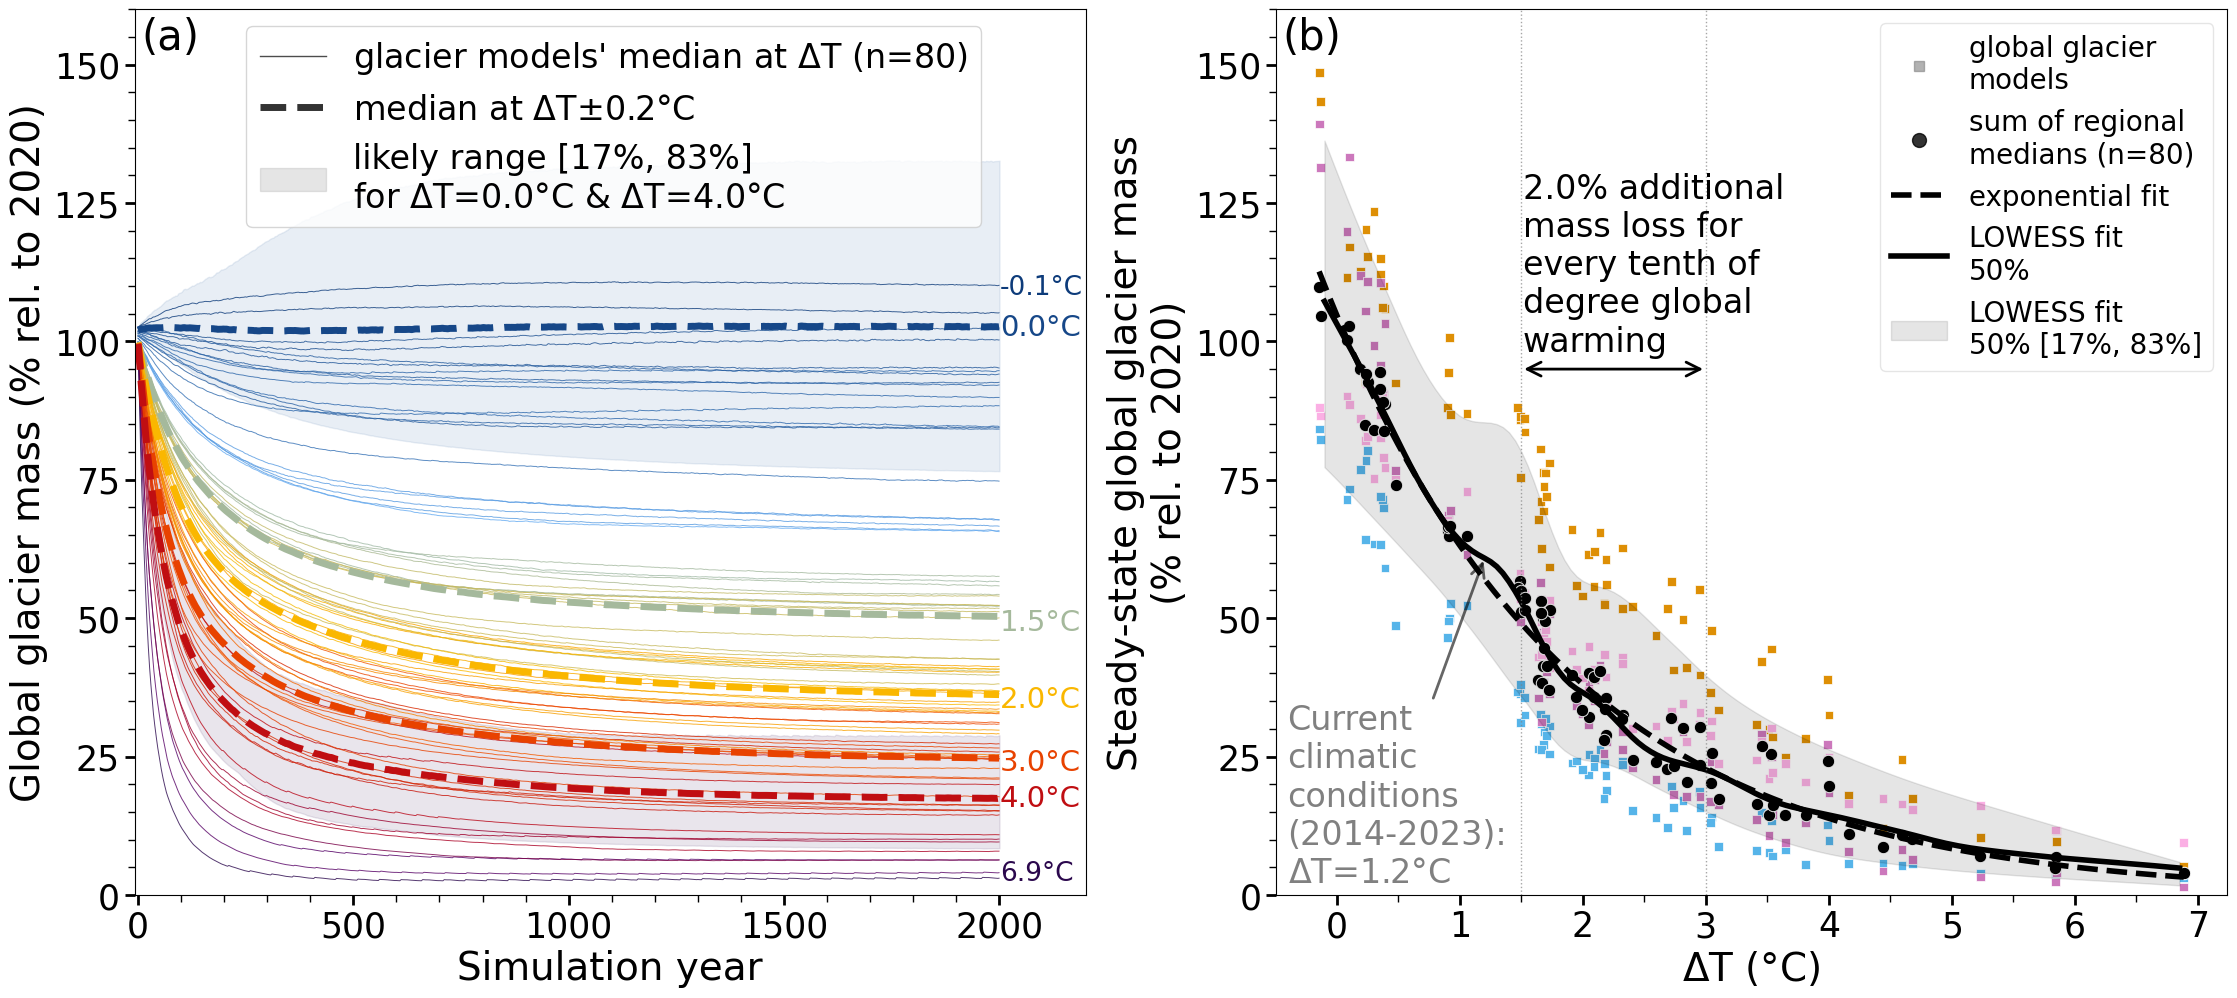

In [30]:
only_90perc = True
show_text = False
qs = [0.17, 0.5, 0.83] ### once we have all data,this needs to be updated ... 

get_vol_timeseries_temp_ch_Xyr_glob_glacier_portrait(region='global', perc=66, sim_year=2000, 
                                                     avg_over = '3yr', # it almost makes no difference fo rthe steady state, but is better for year 0 ...
                                                     smooth_values_percentiles=1,
                                                    exp_decay_temp_fit=False, temp_above_0_8=False,
                                                     shift_years=True,
                                                     landscape = True, show_slope_fit=True, 
                                                    show_min_max_quantiles_a=False, select_opt='', complex_aggregation_scheme=True)
plt.savefig(f'figures/fig1.pdf', bbox_inches='tight')
plt.savefig(f'figures/fig1.png', bbox_inches='tight')


### Suppl. figure of regional vs global warming ... 

global_glacier median ratio: 1.8     median_ratio_15_30:  1.9    fitted slope: 1.8
RGI19_glacier median ratio: 1.1     median_ratio_15_30:  1.0    fitted slope: 1.2
RGI03_glacier median ratio: 2.4     median_ratio_15_30:  2.6    fitted slope: 2.4
RGI01_glacier median ratio: 1.5     median_ratio_15_30:  1.6    fitted slope: 1.5
RGI05_glacier median ratio: 1.9     median_ratio_15_30:  2.0    fitted slope: 2.0
RGI09_glacier median ratio: 3.1     median_ratio_15_30:  3.2    fitted slope: 3.2
RGI04_glacier median ratio: 2.2     median_ratio_15_30:  2.2    fitted slope: 2.1
RGI07_glacier median ratio: 3.0     median_ratio_15_30:  3.2    fitted slope: 2.9
RGI17_glacier median ratio: 0.7     median_ratio_15_30:  0.7    fitted slope: 0.8
RGI06_glacier median ratio: 0.9     median_ratio_15_30:  1.1    fitted slope: 1.1
RGI13_glacier median ratio: 1.4     median_ratio_15_30:  1.4    fitted slope: 1.4
RGI14_glacier median ratio: 1.4     median_ratio_15_30:  1.4    fitted slope: 1.4
RGI02_glacier m

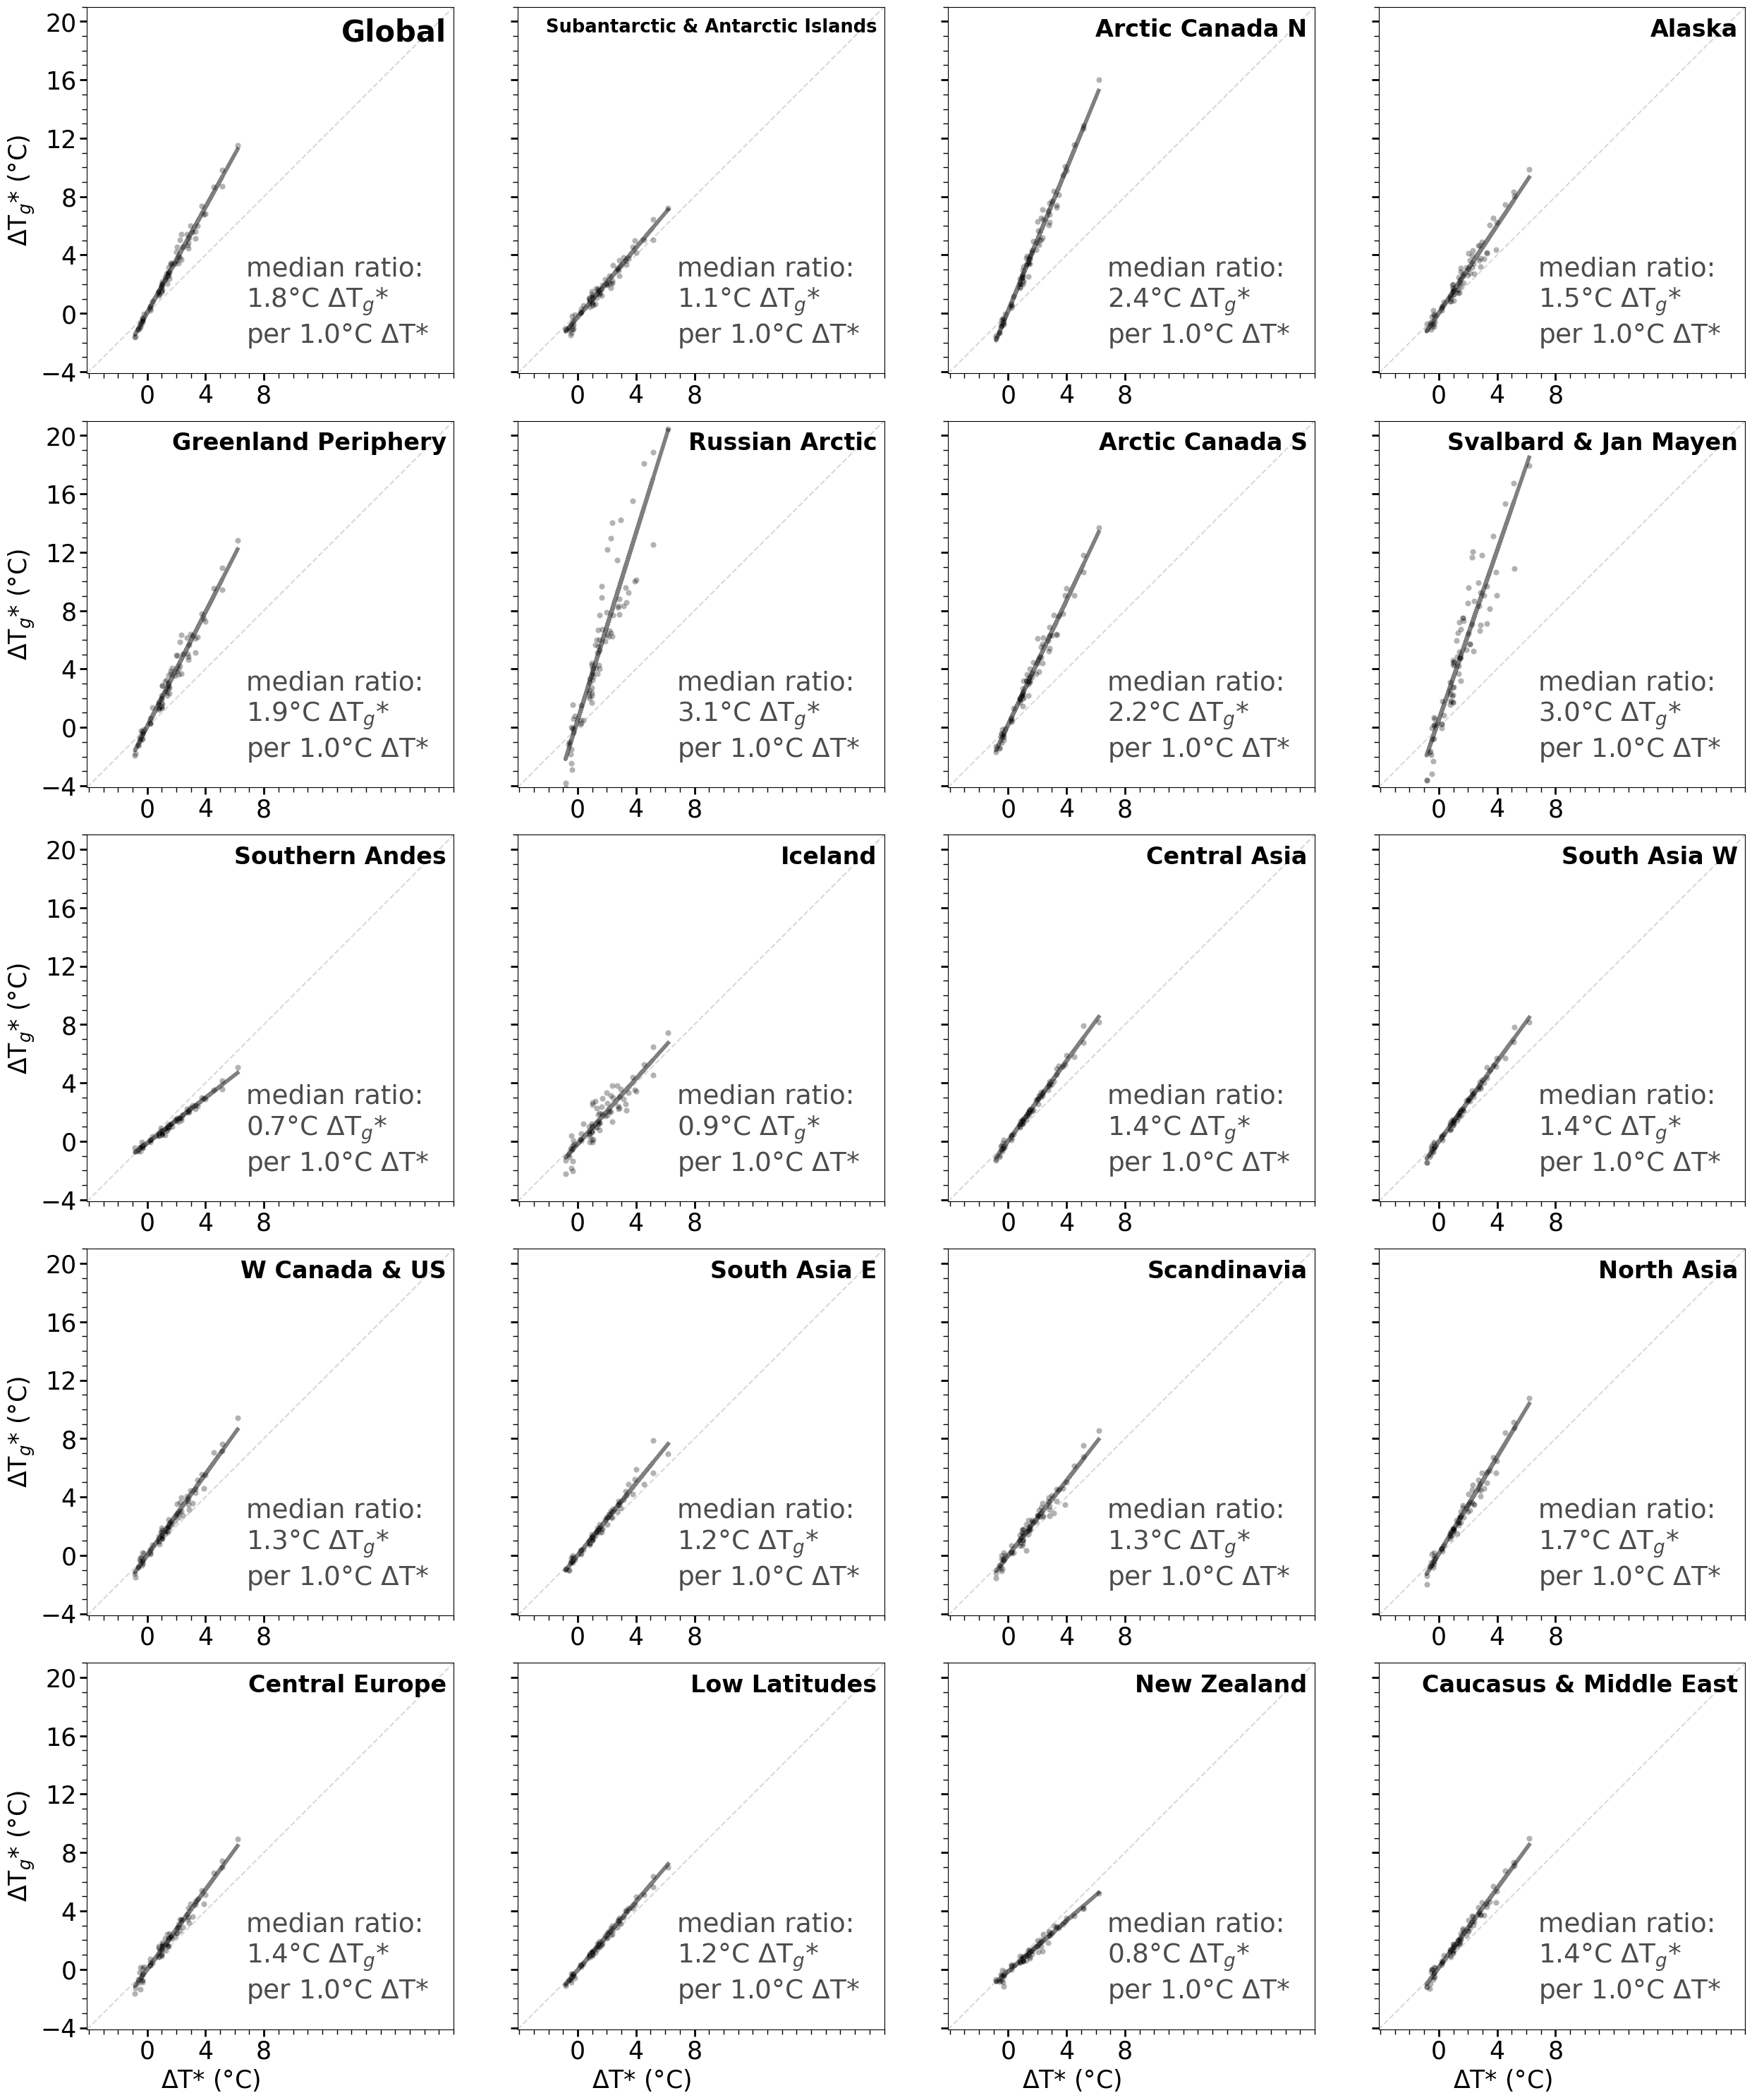

In [25]:
if 'All' in rgi_regs_sel:
    rgi_regs_sel_all = rgi_regs_sel
else:
    rgi_regs_sel_all = [*['All'],*rgi_regs_sel]

fig, axs = plt.subplots(5,4,figsize=(25,30), sharey=True, sharex=False) #, sharey='row') #, sharex=True)
plt.rc('font', size=25.5)  
for j, rgi_reg in enumerate(rgi_regs_sel_all):
    if j<4:
        ax = axs[0][j]
    elif j <8:
        ax = axs[1][j-4]
    elif j <12:
        ax = axs[2][j-8]
    elif j <16:
        ax = axs[3][j-12]
    elif j <20:
        ax = axs[4][j-16]

        
    if rgi_reg == 'All':
        ax.text(0.98, 0.97, 'Global', color='black', weight='bold',transform=ax.transAxes, fontsize=30, va='top', ha='right')
        #ax.set_title(f'Global glacier volume after {sim_year} years')
    else:
        nam = d_reg_num_name[rgi_reg]
        if rgi_reg == '19':
            fs_rgi = 16.5
        else:
            fs_rgi = 22
        fs_rgi = fs_rgi+2
        ax.text(0.98, 0.97, f'{nam}',#, #f'{rgi_reg}-{nam}',
                color='black',
                weight='bold',
                transform=ax.transAxes, fontsize=fs_rgi, va='top', ha='right')

        
    pd_global_temp_exp_m = get_glob_temp_exp(region='global')

    if rgi_reg == 'All':
        region = 'global_glacier'
    else:
        region = f'RGI{rgi_reg}_glacier'
    pd_global_temp_exp_m_glac = get_glob_temp_exp(region=region)
    pd_global_temp_exp_m.loc[pd_global_temp_exp_m_glac.index, 'temp_ch_ipcc_glacier'] = pd_global_temp_exp_m_glac['temp_ch_ipcc'].values
    pd_t = pd_global_temp_exp_m
    # we are just interested in the differences to 1986-2005
    # so let's remove the +0.69°C that we assumed to occur everywhere (globally, this is the estimate of warming from preindustrial levels to 1986-2005 from IPCC AR6)
    pd_t['temp_ch_ipcc'] = pd_t['temp_ch_ipcc']-0.69
    pd_t['temp_ch_ipcc_glacier'] = pd_t['temp_ch_ipcc_glacier']-0.69
    inset_ax = ax
    sns.scatterplot(data=pd_t, ax = inset_ax,
                    x='temp_ch_ipcc', y='temp_ch_ipcc_glacier',
                    color='black', alpha = 0.3,
                    #hue='temp_ch_ipcc', palette='flare',
                    legend=False)
    #inset_axes.set_title(f'Glacier area-weighted vs global\n'+r'temperature changes ($\Delta$T)'+'\ncompared to preindustrial levels')
    if j >=16:
        inset_ax.set_xlabel(r'$\Delta$T* (°C)                ') # $_{global}$ (°C)')# + '\n(°C, compared to pre-industrial levels)')
    else:
        inset_ax.set_xlabel('')
    
    
    inset_ax.set_ylabel(r'$\Delta$T$_{g}$* (°C)')

    #inset_ax.grid(alpha=0.5)
    # add linear fit
    slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_t['temp_ch_ipcc'].values, pd_t['temp_ch_ipcc_glacier'])
    inset_ax.plot(pd_t['temp_ch_ipcc'], slope*pd_t['temp_ch_ipcc'].values + intercept, color = 'black', alpha = 0.5, lw=4)
    ratio = np.median(pd_t['temp_ch_ipcc_glacier'].values/pd_t['temp_ch_ipcc'].values)
    pd_t_15_30 = pd_t.loc[(pd_t.temp_ch_ipcc>=1.5)&(pd_t.temp_ch_ipcc<=3.0)]
    median_ratio_15_30 = np.median(pd_t_15_30['temp_ch_ipcc_glacier'].values/pd_t_15_30['temp_ch_ipcc'].values)
    print(region, 'median ratio:', ratio.round(1), '    median_ratio_15_30: ', median_ratio_15_30.round(1), '   fitted slope:' , slope.round(1))

    #inset_ax.annotate(f'fitted slope:\n{slope:.1f}°C '+r'$\Delta$T$_{glacier}$'+'\nper 1.0°C '+r'$\Delta$T$_{global}$',
    inset_ax.annotate(f'median ratio:\n{ratio:.1f}°C '+r'$\Delta$T$_{g}$*'+'\nper 1.0°C '+r'$\Delta$T*',
                  xy=(6.8,-2),
                  xytext=(6.8,-2),
                  fontsize = 27,
                  #arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), 
                      color='black', alpha=0.7)
    
    #inset_ax.annotate(f'only for 1.5-3.0°C:\n{median_ratio_15_30:.1f}°C '+r'$\Delta$T$_{g}$*'+'\nper 1.0°C '+r'$\Delta$T*',
    #          xy=(6.7,0.5),
    #          xytext=(6.7,0.5),
    #          fontsize = 21.5,
    #          #arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), 
    #              color='black', alpha=0.7)
    arrow_annotate = False
    if arrow_annotate:
        if region == 'global_glacier':
            inset_ax.annotate(f'{slope:.1f}°C '+r'$\Delta$T$_{g}$*'+'\nper 1.0°C '+r'$\Delta$T',
                              xy=(3,slope*3 + intercept),
                              xytext=(4-2-0.5,slope*4 + intercept-8),
                              fontsize = 21,
                              arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='black', alpha=0.7)
        else:
            inset_ax.annotate(f'{slope:.1f}°C '+r'$\Delta$T$_{g,1986-2005}$*'+f'\nRGI{rgi_reg} per'+'\n1.0°C '+r'$\Delta$T',
                              xy=(3,slope*3 + intercept),
                              xytext=(0.4,0.04),    #(4-2,slope*4 + intercept-8),
                              textcoords='axes fraction', fontsize=20,
                       arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='black', alpha=0.7)

    ylim0,ylim1 = inset_ax.get_ylim()
    xlim0,xlim1 = inset_ax.get_xlim()
    lim0 = (pd_global_temp_exp_glac.temp_ch_ipcc.min()-0.63) -0.02# ylim0-0.02#min(ylim0, xlim0)
    lim1 = 21 #max(ylim1, xlim1)
    ax.plot([lim0, lim1], [lim0, lim1], color='gray', linestyle='--', alpha = 0.3)

    inset_ax.set_xticks(np.arange(0,9,4))
    inset_ax.set_yticks(np.arange(-4,np.max([ylim1,xlim1]),4))
    inset_ax.minorticks_on()
    
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    inset_ax.set_xlim([lim0, lim1])
    inset_ax.set_ylim([lim0, lim1])
    inset_ax.set_aspect('equal')

#plt.tight_layout()
plt.tight_layout(pad=0.35, w_pad=0.02, h_pad=0.02)
plt.savefig('figures/supplements/suppl_reg_vs_global_glacier_temp_change_per_rgi_region_1986_2005.png')
plt.savefig('figures/supplements/suppl_reg_vs_global_glacier_temp_change_per_rgi_region_1986_2005.pdf')

**additional figure variants of Fig. 1 for regions instead of globally**

['PyGEM-OGGM_v13' 'GloGEMflow' 'GloGEMflow3D' 'OGGM_v16' 'GLIMB'
 'Kraaijenbrink']
0.0 5 0.020107092206236098
172.24350758065515
1.5 14 1.5970631102397388
66.44880230260769
2.0 12 2.0838111906835044
40.10343312293261
3.0 7 2.964579003110285
19.736707430126057
4.0 4 3.990951133436012
8.584014599013958
[('ipsl-cm6a-lr', '1851-1870_hist') ('ipsl-cm6a-lr', '1901-1920_hist')
 ('mpi-esm1-2-hr', '1851-1870_hist') ('mpi-esm1-2-hr', '1901-1920_hist')
 ('mri-esm2-0', '1851-1870_hist')]
min_t <xarray.DataArray 'experiments' (experiments: 1)>
array([('ipsl-cm6a-lr', '1901-1920_hist')], dtype=object)
Coordinates:
  * experiments      (experiments) object MultiIndex
  * gcm              (experiments) <U13 'ipsl-cm6a-lr'
  * period_scenario  (experiments) <U16 '1901-1920_hist' <xarray.Dataset>
Dimensions:                        (year_after_2020: 4951, experiments: 1)
Coordinates:
  * year_after_2020                (year_after_2020) float32 0.0 ... 4.95e+03
  * experiments                    (experime

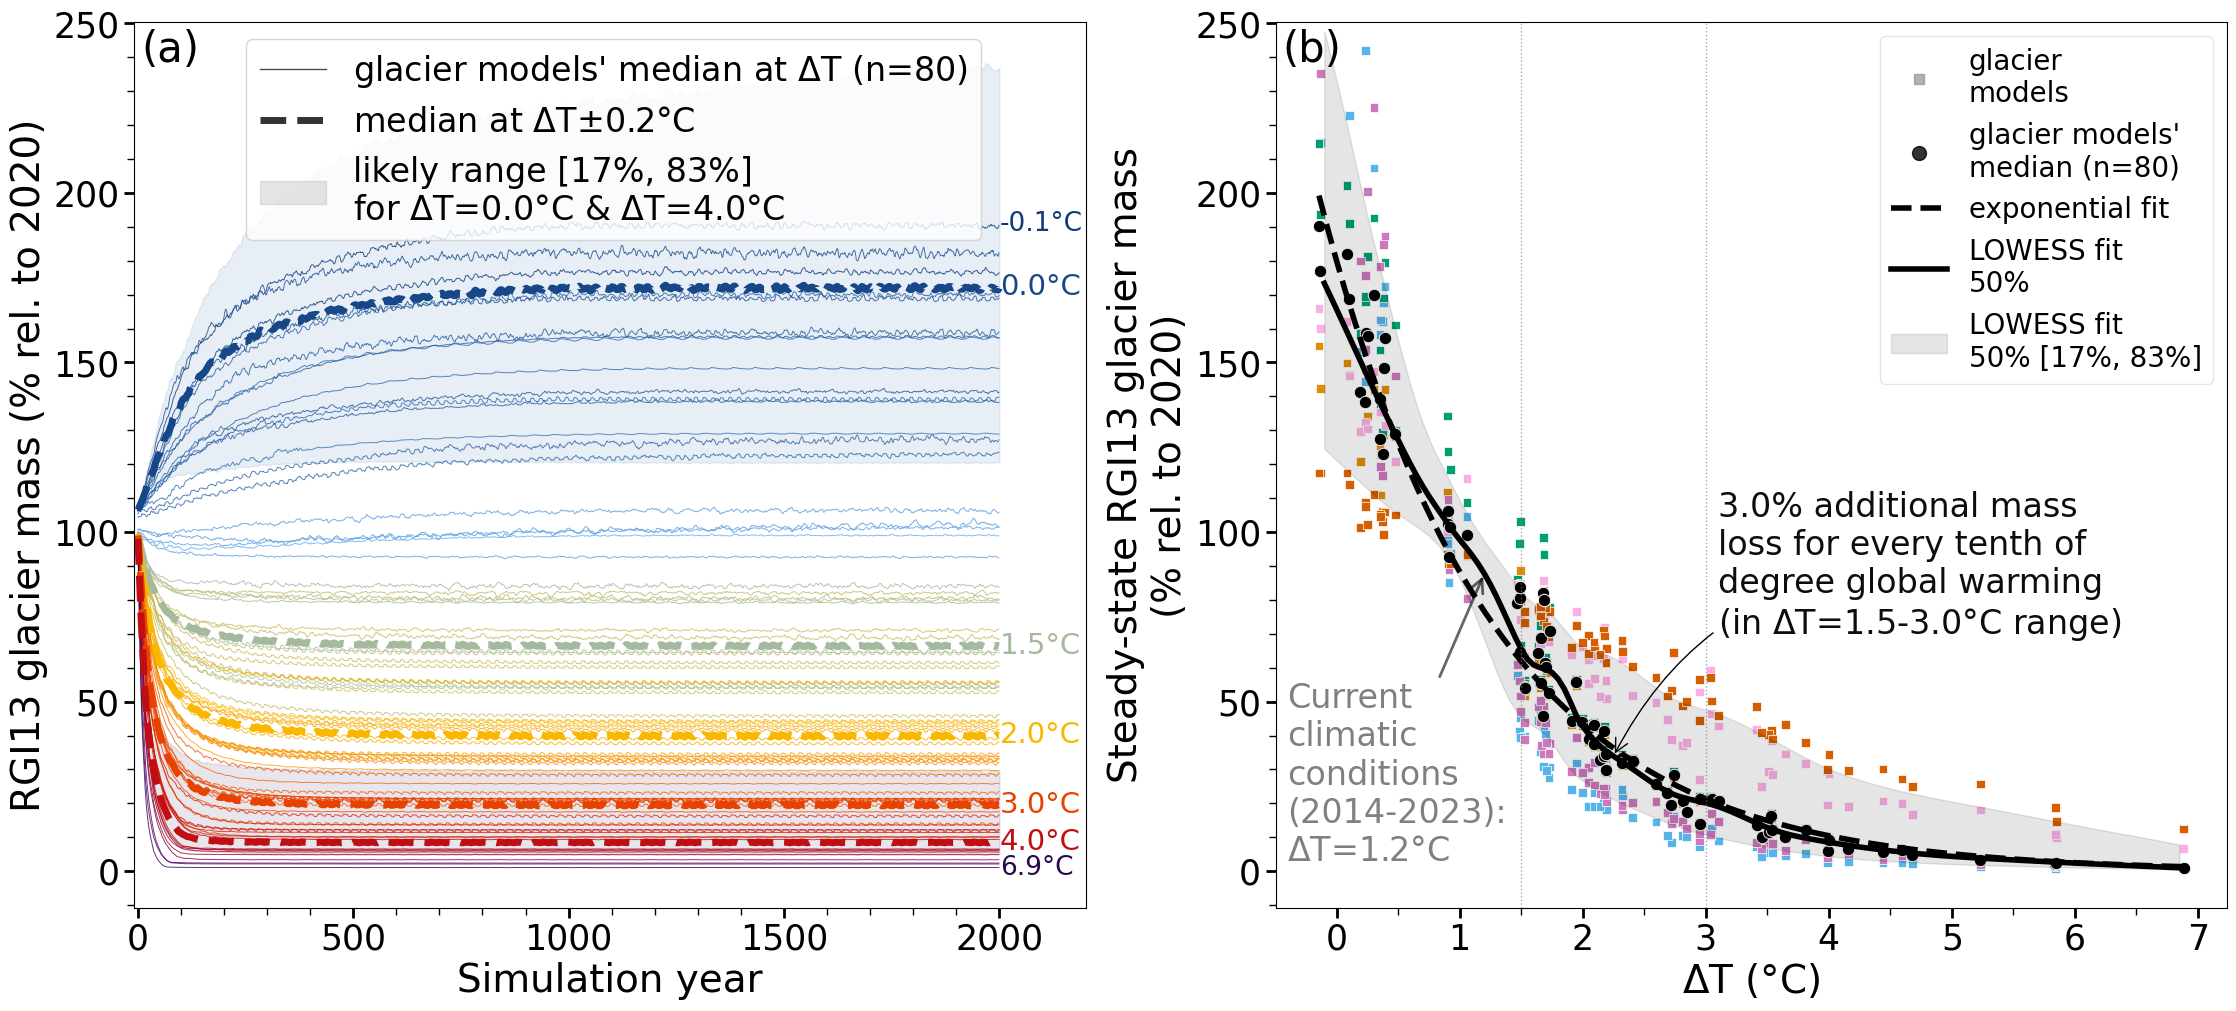

In [31]:
# could also compute Fig. 1 for every individual region ... but removed this for now ... 
#rgi_regs = []
#for rgi_reg in np.arange(1,20,1):
#    if rgi_reg < 10:
#        rgi_reg = '0'+str(rgi_reg)
#    else:
#        rgi_reg = str(rgi_reg)
#    rgi_regs.append(rgi_reg)

get_vol_timeseries_temp_ch_Xyr_glob_glacier_portrait(region=f'RGI13_glacier', perc=66, sim_year=2000, 
                                                         avg_over = '3yr', # it almost makes no difference fo rthe steady state, but is better for year 0 ...
                                                         smooth_values_percentiles=1,
                                                        exp_decay_temp_fit=False, temp_above_0_8=False,
                                                         shift_years=True,
                                                         landscape = True, show_slope_fit=True, 
                                                        show_min_max_quantiles_a=False, select_opt='', complex_aggregation_scheme=True)

In [38]:
fill_option = 'repeat_last_20yrs'
ds_reg_models_extend = xr.open_dataset(f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc')
pd_global_temp_exp_m = get_glob_temp_exp(region='global')



plt.rc('font', size=18)  

markers = ['^', 'X','s','o','D','v']

norm = plt.Normalize(vmin=pd_global_temp_exp_m['temp_ch_ipcc'].min(),
                     vmax=pd_global_temp_exp_m['temp_ch_ipcc'].max())
cmap = sns.color_palette('flare', as_cmap=True) #sns.cubehelix_palette(light=1, as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# plot specific delta T:
col_temp_l = []
exp_l = []
for temp in [0,1.5,2,3,4,5]: #,5,6]:
    exp = np.abs(pd_global_temp_exp_m-temp).sort_values(by='temp_ch_ipcc').iloc[0].name
    #sm.colorbar.norm...
    col_temp = cmap(norm(pd_global_temp_exp_m.loc[exp]['temp_ch_ipcc']))
    col_temp_l.append(col_temp)
    exp_l.append(exp)

**Attention: Fig. below probably needs to be updated with the function `resp_time_estimate`**